In [38]:
# imports
import numpy as np
from scipy.optimize import minimize
import scipy.stats as ss
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error
import time
import pymc as pm
import arviz as az

In [2]:
# Helper functions:
def generate_data(seed=121, nsteps=365, gt_sig=0.25, gt_eps=0.4, gt_pOut_g=0.03, nb_stds=2, 
                  censored_proportion=20,
                  init=np.random.uniform(),
                  discard_those=[1,2,3,5,6]):
    # Script de génération des données. Ne pas modifier cette cellule dans le cadre de ce TP.
    
    # Initialisation de la graine :
    np.random.seed(seed)
    
    # Génération du vecteur de dates :
    dates = []
    dates.append(pd.to_datetime('2021-01-01'))
    
    for i in range(1,nsteps):
        dates.append(dates[0] + datetime.timedelta(days=i))
    
    df = pd.DataFrame()
    df['dates'] = dates
    df['weekday'] = df.dates.dt.weekday
    df['id'] = df.index.tolist()
    
    # Génération du processus latent X[t] selon un modele RW(1) :
    Xt = np.zeros(nsteps)
    Xt[0] = init # premier point fixé de manière à obtenir des valeurs crédibles pour le SARS-CoV-2
    for i in range(1,nsteps):
        Xt[i] = Xt[i-1] + np.random.normal(loc=0, scale=gt_sig)
    
    df['Xt'] = Xt
    
    # Génération du vecteur d'observations Y[t] dans le cas nominal :
    Yt = np.zeros(df.shape[0])
    for i in range(df.shape[0]):
        Yt[i] = Xt[i] + np.random.normal(loc=0, scale=gt_eps)
    
    df.loc[df.weekday.isin(discard_those), 'id'] = np.nan # on n'observe que les jours 0 et 4 (lundi et vendredi)
    obsAt = np.array(df.loc[~df['id'].isna()].index.tolist())
    
    # Mise à jour de la graine pour les outliers :
    np.random.seed(seed + 33)
    
    # Génération des outliers :
    Y_std = np.nanstd(Yt)
    a = np.nanmin(Yt) - nb_stds*Y_std
    b = np.nanmax(Yt) + nb_stds*Y_std
    outliers_indexes = np.random.choice(obsAt, size=int(obsAt.shape[0]*gt_pOut_g), replace=False)
    Yt[outliers_indexes] = np.random.uniform(low=a, high=b, size=outliers_indexes.shape[0])
    
    # Ajout de la censure sur 20% des échantillons :
    thresh = np.percentile(df.loc[~df.Xt.isna()].Xt.values, censored_proportion)
    df['Yt'] = Yt
    df.loc[df.Yt<= thresh, 'Yt'] = thresh
    df.loc[df.id.isna(), 'Yt'] = np.nan   

    return df, outliers_indexes, thresh

def visualize_raw_data(df, outliers_indexes):
    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10) 
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(df.dates.values, df.Xt.values, label='$X_t$', color='deepskyblue', linewidth=10)
    ax_dict['A'].plot(df.dates.values, df.Xt.values, color='black', linewidth=3)
    ax_dict['A'].scatter(df.dates.values, df.Yt.values, label='$\hat{X}_t$', color='orange', edgecolor='black', s=360, zorder=1,
                        linewidths=1.5, alpha=0.9)
    
    outliers_points = ax_dict['A'].scatter(df.dates.values[outliers_indexes], df.Yt.values[outliers_indexes],
                         color='none', edgecolor='red', s=520, zorder=2, linewidth=5, label="True outliers")
    
    
    ax_dict['A'].set_ylabel("Gene concentration (GU/L) - Log scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=3)
    plt.grid()
    plt.show()    

def visualize_smoothed_data(df, outliers_indexes, scou, solution, visualize_solution=True):
    LABEL_SIZE = 30
    TICK_SIZE = 30
    TITLE_SIZE = 38
    LEGEND_SIZE = 30
    DATES_SIZE = 18
    figsize = (28, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = False#True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        A
        """
    )
    
    ### A
    ax_dict['A'].plot(df.dates.values, df.Xt.values, label='$X_t$', color='deepskyblue', linewidth=8, zorder=3)
    ax_dict['A'].plot(df.dates.values, df.Xt.values, color='black', linewidth=3, zorder=3)

    if visualize_solution:
        ax_dict['A'].plot(df.dates.values, solution.muX.values, label='$X^*_{t_{opt}}$ - Solution', color='green', linewidth=8, zorder=3)
    ax_dict['A'].plot(df.dates.values, scou.muX, label='$X^*_{t_{opt}}$ - Your implementation', color='orange', linewidth=5, zorder=3)
    
    scatter_points = ax_dict['A'].scatter(df.dates.values, df.Yt.values, label='$\hat{X}_t$', 
                         c=scou.pointwise_pout,
                         cmap='bwr', edgecolor='black', s=360, zorder=2,
                         linewidths=1.5, alpha=0.9, vmin=0, vmax=1)
    
    censored_observations = df.loc[df.Yt<=thresh]
    
    censored_points = ax_dict['A'].scatter(censored_observations.dates.values,
                                           censored_observations.Yt.values, label='$\hat{X}_{t_{Censored}}$', 
                         color='none', edgecolor='darkorange', s=520, zorder=1, linewidth=5)
    
    outliers_points = ax_dict['A'].scatter(df.dates.values[outliers_indexes], df.Yt.values[outliers_indexes],
                         color='none', edgecolor='red', s=520, zorder=1, linewidth=5, label="True outliers")
    
    ax_dict['A'].set_ylabel("Gene concentration (GU/L) - Log scale")
    ax_dict['A'].set_xlabel("Sampling date")
    ax_dict['A'].tick_params(axis='x', labelsize=TICK_SIZE)
    ax_dict['A'].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict['A'].grid(linewidth=1, color='black', alpha=0.8)
    
    ### Outlier probability legend:
    cmin, cmax = 0.0, 1.0 
    axins1 = inset_axes(ax_dict['A'], width='2%', height='100%', loc='right', borderpad=0)
    axins1.grid(False)
    cbar = fig.colorbar(scatter_points, cax=axins1, orientation='vertical')
    
    # Setting tick limits:
    cbar.set_ticks([cmin, cmax])
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator([cmin, cmax]))
    
    # Standardizing the float format displayed:
    decimal_places = 1
    cbar.ax.set_yticklabels([f"{cmin:.{decimal_places}f}", f"{cmax:.{decimal_places}f}"], fontsize=TICK_SIZE)
    
    # Placing the label at the right spot:
    cbar.ax.set_ylabel('Outlier probability', size=TICK_SIZE, labelpad=-35)
    
    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=6)
    plt.grid()
    plt.show()

# Fonction de validation des résultats, ne pas modifier

def cmp(s, scou, solution_dict, rtol):

    if s=='pointwise_pout':
        tmp1 = getattr(scou, s)
        tmp2 = solution_dict[s]

        tmp1 = tmp1[np.where(~np.isnan(tmp1))]
        tmp2 = tmp2[np.where(~np.isnan(tmp2))]

    else:
        tmp1 = getattr(scou, s)
        tmp2 = solution_dict[s]
        
    maxdiff = np.max(np.abs(tmp1 - tmp2))
    ex = np.allclose(tmp1, tmp2, rtol)
    
    print(f'{s:15s} | exact: {str(ex):5s} | maxdiff: {maxdiff}')

In [3]:
def get_95CI(signal, alpha=5.0):
    """Computes the (default to 95%) confidence intervals of a sequential signal.

    Parameters
    ----------
    signal : {array-like} of shape (n_samples, n_timesteps).
    The matrix of samples. Each row represents a sample, while each column is associated to a timestep.

    alpha : float.
    1 - CI_range, where CI_range represents the range of the confidence interval.

    Returns
    -------
    CI95_lower : {array} of shape (n_timesteps, ).
    The lower bound of the (1 - alpha) confidence interval.

    CI95_upper : {array} of shape (n_timesteps, ).
    The upper bound of the (1 - alpha) confidence interval.
    """
    CI95_lower = []
    CI95_upper = []

    for timestep in range(signal.shape[1]):
        
        drawn_at_time_t = signal[:,timestep] # Gather the samples at time t
        lower_p = alpha / 2.0 # Computes the lower bound
        lower = np.percentile(drawn_at_time_t, lower_p) # Retrieves the observation at the lower percentile index
        upper_p = (100 - alpha) + (alpha / 2.0) # Computes the upper bound
        upper = np.percentile(drawn_at_time_t, upper_p) # Retrieves the observation at the upper percentile index

        CI95_lower.append(lower)
        CI95_upper.append(upper)
        
    return np.array(CI95_lower), np.array(CI95_upper)


def normal_distribution_pdf(x, loc=0, scale=1): 
    """Computes the normal probability density function (PDF) for each value in the input vector x.
    NB : Empirically much faster than scipy's, probably related to sample size I guess.

    Parameters
    ----------
    x : {array} of shape (n_samples, ).
    The array upon which the PDF is going to be applied.

    loc : float.
    The mean of the normal distribution.

    scale : float.
    The standard deviation of the normal distribution.

    Returns
    -------
    pdf : {array} of shape (n_samples, ).
    The PDF related to the input vector x.
    """
    A = 1 / (scale * np.sqrt(2 * np.pi))
    B = - (1/2) * ((x - loc)/ scale) ** 2
    
    return A * np.exp(B)

def approx_standard_normal_cdf_sw(x, loc=0, scale=1):
    """Computes the normal cumulative distribution function (CDF) for each value in the input vector x,
    using Page's approximation formula.

    Parameters
    ----------
    x : {array} of shape (n_samples, ).
    The array upon which the CDF is going to be applied.

    loc : float.
    The mean of the normal distribution.

    scale : float.
    The standard deviation of the normal distribution.

    Returns
    -------
    cdf : {array} of shape (n_samples, ).
    The CDF related to the input vector x.
    """
    xx = (x - loc) / scale
    return 0.5 * (1.0 + np.tanh(np.sqrt(2.0 / np.pi) * (xx + 0.044715 * xx**3)))

def censored_normal_logcdf(lod, eps, latent):
    """Computes the logarithm of the normal cumulative distribution function (CDF) for each observation in the input vector lod,
    based on the assumption that lod|latent \sim \mathcal{N}(latent, eps**2) in pyMC's framework.

    Parameters
    ----------
    lod : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    eps : float.
    The standard deviation of the observations w.r.t the latent variable.

    latent : {array} of shape (n_steps, ).
    The array of the sequential values for the latent variable.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector lod.
    """
    return pm.logcdf(pm.Normal.dist(mu=latent, sigma=eps), lod)

def censored_uniform_logcdf(lod, a, b):
    """Computes the logarithm of the uniform cumulative distribution function (CDF) for each observation in the input vector lod,
    based on the assumption that lod|latent \sim \mathcal{U}(a, b) in pyMC's framework.

    Parameters
    ----------
    lod : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    a : float.
    Lower bound of the uniform distribution.

    b : {array} of shape (n_steps, ).
    Upper bound of the uniform distribution.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector lod.
    """
    return pm.logcdf(pm.Uniform.dist(lower=a, upper=b), lod)


def censored_normal_logcdf_LoQ(loqd, eps, latent):
    """Computes the logarithm of the normal cumulative distribution function (CDF) for each observation in the input vector value,
    based on the assumption that value|latent \sim \mathcal{N}(latent, eps**2) in pyMC's framework.

    Parameters
    ----------
    value : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    eps : float.
    The standard deviation of the observations w.r.t the latent variable.

    latent : {array} of shape (n_steps, ).
    The array of the sequential values for the latent variable.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector value.
    """
    contrib_a = pm.math.exp(censored_normal_logcdf(loqd[:,0], eps, latent))
    contrib_b = pm.math.exp(censored_normal_logcdf(loqd[:,1], eps, latent))
    return pm.math.log(contrib_b - contrib_a)

def censored_uniform_logcdf_LoQ(loqd, a, b):
    """Computes the logarithm of the uniform cumulative distribution function (CDF) for each observation in the input vector value,
    based on the assumption that value|latent \sim \mathcal{U}(a, b) in pyMC's framework.

    Parameters
    ----------
    value : {array} of shape (n_steps, ).
    The array of sequential observations. Can contain np.nan values corresponding to unobserved timesteps.

    a : float.
    Lower bound of the uniform distribution.

    b : {array} of shape (n_steps, ).
    Upper bound of the uniform distribution.

    Returns
    -------
    cdf : {array} of shape (n_steps, ).
    The CDF related to the input vector value.
    """
    contrib_a = pm.math.exp(censored_uniform_logcdf(loqd[:,0], a, b))
    contrib_b = pm.math.exp(censored_uniform_logcdf(loqd[:,1], a, b))
    return pm.math.log(contrib_b - contrib_a)

class SCOU():
    """
    Bayesian implementation of the SCOU algorithm.

    SCOU is an extended Kalman Smoother, taking into consideration
    left-censored values as well as outliers.

    Parameters
    ----------
    p_out_frozen : bool, default=False
        Whether to estimate the a priori outlier probability. If set
        to False, a deterministic value will be used.

    p_out_deterministic : float, default=None
        The value to be used for p_out if p_out_frozen is set to True.

    tuning_iters : int, default=4000
        The number of tuning iterations used for the NUTS MCMC sampler.

    sampling_iters : int, default=2000
        The number of sampling iterations used for the NUTS MCMC sampler.

    nb_chains : int, default=3
        The number of Markov chains used for the NUTS MCMC sampler.

    export_chains : bool, default=False
        Whether to export the chains of parameters in a *.nc file.

    export_name : string, default='default.nc'
        The name of the export file if export_chains is set to True.

    RW_order : {1, 2}, default=1
        The order of the gaussian random walk of the underlying process.

    Attributes
    ----------
    latent_posterior_distribution : array of shape (n_samples, n_steps) 
        The posterior distribution of the latent variable.

    muX : array of shape (n_steps, )
        The average signal of the latent variable, performed over all samples.

    CIU : array of shape (n_steps, )
        The upper bound of the 95% CI of the latent variable.

    CIL : array of shape (n_steps, )
        The lower bound of the 95% CI of the latent variable.

    pointwise_pout : array of shape (n_steps, )
        The posterior probability of each observation to be an outlier.

    SCOU_model : 

    SCOU_traces : 

    T_ronde :

    borne_inf :

    borne_sup : 

    unobserved_indexes : 

    

    See Also
    --------

    Notes
    -----
    This algorithm was tailor-made to meet the expectations of the Obepine research consortium
    during the Covid-19 pandemic in terms of microbiological data processing.

    References
    ----------

    .. [1] M. Courbariaux et al., "A Flexible Smoother Adapted to Censored Data
           With Outliers and Its Application to SARS-CoV-2 Monitoring in Wastewater",
           Frontiers in Applied Mathematics and Statistics, 2022. 
           https://doi.org/10.3389/fams.2022.836349

    Examples
    --------
    >>> TODO
    """

    def __init__(self, observations,
                 censoring_threshold_lod_vect=np.array([]),
                 censoring_threshold_loq_vect=np.array([]),
                 p_out_frozen=False,
                 p_out_deterministic=None,
                 tuning_iters=4000,
                 sampling_iters=2000,
                 nb_chains=3,
                 export_chains=False,
                 export_name='default.nc',
                 RW_order=1):

        self.observations = observations
        self.censoring_threshold_lod_vect = censoring_threshold_lod_vect
        self.censoring_threshold_loq_vect = censoring_threshold_loq_vect
        self.n_steps = self.observations.shape[0]
        self.rng = np.random.default_rng(666)
        self.tuning_iters = tuning_iters
        self.sampling_iters = sampling_iters
        self.nb_chains = nb_chains
        self.export_name = export_name
        self.export_chains = export_chains
        self.p_out_frozen = p_out_frozen
        self.p_out_deterministic = p_out_deterministic
        self.RW_order = RW_order


    def obs_discrimination(self):
        """Defines the set of observations, whether they are censored or not, which timesteps are not observed
        and the lower and upper bounds of the uniform distribution.
        
        """
        self.unobserved_indexes = np.where(np.isnan(self.observations))[0]

        if len(self.censoring_threshold_loq_vect)>0:
            self.observations_below_LoD = np.where(self.observations<=self.censoring_threshold_lod_vect)[0]
            self.observations_above_LoQ = np.where(self.observations>self.censoring_threshold_loq_vect)[0]
            self.observations_between_LoQD = np.where((self.observations>self.censoring_threshold_lod_vect) & (self.observations<=self.censoring_threshold_loq_vect))[0]
        else:
            self.observations_below_LoD = np.where(self.observations<=self.censoring_threshold_lod_vect)[0]
            self.observations_above_LoQ = np.where(self.observations>self.censoring_threshold_lod_vect)[0]
            self.observations_between_LoQD = np.array([])

        self.T_ronde = np.setdiff1d(np.arange(self.observations.shape[0]), self.unobserved_indexes)
        self.borne_inf, self.borne_sup = np.nanmin(self.observations) - 2*np.nanstd(self.observations), np.nanmax(self.observations) + 2*np.nanstd(self.observations)


    def model_definition(self):
        """Defines the model parameters and observation in pyMC's framework.
        
        """
        self.obs_discrimination()

        with pm.Model() as self.SCOU_model:
            ### ----- Priors definition ----- ###
            sig = pm.InverseGamma('sig', alpha=2, beta=1) # Latent process innovation's drift
            eps = pm.InverseGamma('eps', alpha=2, beta=1) # Observations standard deviation w.r.t latent process
            if self.p_out_frozen:
                p_out = self.p_out_deterministic # Outliers a priori proportion can be frozen to a deterministic value
            else:
                p_out = pm.Beta('p_out', alpha=2, beta=5) # Outliers a priori proportion                

            init_mean = np.nanmean(self.observations)
            init_std = 5
            init_dist = pm.Normal.dist(init_mean, init_std, shape=self.n_steps)
            if self.RW_order==1:
                latent = pm.AR("latent", rho=np.array([1]), sigma=sig, shape=self.n_steps, init_dist=init_dist) # Latent process X[t] defined as (AR(1))
            elif self.RW_order==2:
                latent = pm.AR("latent", rho=np.array([2, -1]), sigma=sig, shape=self.n_steps, init_dist=init_dist) # Latent process X[t] defined as (AR(2))

            ### ----- Uncensored data handling ----- ###
            normal_component = pm.Normal.dist(mu=latent[self.observations_above_LoQ], sigma=eps) # Gaussian component for uncensored data
            outlier_component = pm.Uniform.dist(lower=self.borne_inf, upper=self.borne_sup) # Uniform component for outliers

            ### -----  Uncensored data mixture model definition ----- ###
            obs_uncensored = pm.Mixture(
                'obs_uncensored',
                w=[1 - p_out, p_out],
                comp_dists=[normal_component, outlier_component],
                observed=self.observations[self.observations_above_LoQ]
            )

            ### ----- LoD censored data handling ----- ###
            normal_LoD_component = pm.DensityDist.dist(
                eps, latent[self.observations_below_LoD],
                logp=censored_normal_logcdf,
                logcdf=censored_normal_logcdf,
                class_name="normal_LoD_component"
            )

            outlier_LoD_component = pm.DensityDist.dist(
                self.borne_inf, self.borne_sup, 
                logp=censored_uniform_logcdf,
                logcdf=censored_uniform_logcdf,
                class_name="outlier_LoD_component"
            )

            ### -----  Censored data mixture model definition ----- ###
            obs_LoD = pm.Mixture(
                'obs_LoD',
                w=[1 - p_out, p_out],
                comp_dists=[normal_LoD_component, outlier_LoD_component],
                observed=self.observations[self.observations_below_LoD]
            )

            if len(self.censoring_threshold_loq_vect)>0:
                ### ----- LoQ censored data handling ----- ###
                normal_LoQ_component = pm.DensityDist.dist(
                    eps, latent[self.observations_between_LoQD],
                    logp=censored_normal_logcdf_LoQ,
                    logcdf=censored_normal_logcdf_LoQ,
                    class_name="normal_LoQ_component"
                )

                outlier_LoQ_component = pm.DensityDist.dist(
                    self.borne_inf, self.borne_sup, 
                    logp=censored_uniform_logcdf_LoQ,
                    logcdf=censored_uniform_logcdf_LoQ,
                    class_name="outlier_LoD_component"
                )

                loqd_stacked_obs = np.vstack((self.censoring_threshold_lod_vect[self.observations_between_LoQD],
                                           self.observations[self.observations_between_LoQD])).T

                ### -----  Censored data mixture model definition ----- ###
                obs_LoQ = pm.Mixture(
                    'obs_LoQ',
                    w=[1 - p_out, p_out],
                    comp_dists=[normal_LoQ_component, outlier_LoQ_component],
                    observed=loqd_stacked_obs
                )

    def fit(self):
        """Computes the MCMC estimation of the model parameters using the NUTS sampler.

        """
        self.model_definition()

        # Inférence
        with self.SCOU_model:
            self.SCOU_traces = pm.sample(self.sampling_iters, tune=self.tuning_iters, 
                                    chains=self.nb_chains, 
                                    return_inferencedata=True, 
                                    random_seed=self.rng)

        self.params = ['sig', 'eps'] 
        if not self.p_out_frozen:
            self.params.append('p_out')

        print("Raw summary:")
        print(az.summary(self.SCOU_traces, var_names=self.params))
        self.params_summary = az.summary(self.SCOU_traces, var_names=self.params)

        if self.export_chains:
            self.SCOU_traces.to_netcdf(self.export_name)

    def predict(self, selected_chains):
        """Computes the latent distribution, as well as its mean and 95% confidence intervals and pointwise outlier probabilities
        for a subset of selected chains.

        Parameters
        ----------
        selected_chains : {array} of shape (n_selected_chains, ).
        The array of indexes of the selected chains, ranging from 0 to self.nb_chains.
        """
        self.n_samples = len(selected_chains)*self.sampling_iters
        self.latent_posterior_distribution = self.SCOU_traces['posterior']['latent'].values[selected_chains].reshape(self.n_samples, -1)
        self.muX = self.latent_posterior_distribution.mean(axis=0)
        self.CIL, self.CIU = get_95CI(self.latent_posterior_distribution)
        self.compute_pointwise_outlier_probabilities(selected_chains)

        print("Best chain combination summary:")
        print(az.summary(self.SCOU_traces.sel(chain=selected_chains), var_names=self.params))

    def compute_pointwise_outlier_probabilities(self, selected_chains):
        """Computes the pointwise outlier probabilities for a subset of selected chains.

        Parameters
        ----------
        selected_chains : {array} of shape (n_selected_chains, ).
        The array of indexes of the selected chains, ranging from 0 to self.nb_chains.
        """
        nb_draws = self.SCOU_traces['posterior']['eps'].values[selected_chains].shape[1] * len(selected_chains)

        self.pointwise_pout = np.ones(self.observations.shape[0]) * np.nan
        self.pointwise_pout_dist = np.ones((self.observations.shape[0], nb_draws)) * np.nan

        # Vectorizing these computations first so that we don't have to repeat them in the next for loop:
        this_partial_emission_vector = np.ones(self.observations.shape[0]) * (1/(self.borne_sup - self.borne_inf))
        this_partial_emission_vector[self.observations_below_LoD] = ((self.censoring_threshold_lod_vect[self.observations_below_LoD] - self.borne_inf)/(self.borne_sup - self.borne_inf))
        if len(self.censoring_threshold_loq_vect)>0:
            this_partial_emission_vector[self.observations_between_LoQD] = ((self.censoring_threshold_loq_vect[self.observations_between_LoQD] - self.censoring_threshold_lod_vect[self.observations_between_LoQD])/(self.borne_sup - self.borne_inf))

        for this_timestep in self.T_ronde:     
            xhat_t = self.observations[this_timestep]
            x_t = self.SCOU_traces['posterior']['latent'].values[selected_chains].reshape(len(selected_chains)*self.sampling_iters, -1)[:, this_timestep]
            this_epsilon = self.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(len(selected_chains)*self.sampling_iters, )[:,]

            if self.p_out_frozen:
                this_pout = self.p_out_deterministic
            else:
                this_pout = self.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(len(selected_chains)*self.sampling_iters, )[:,]

            if this_timestep in self.observations_below_LoD:
                num = this_pout * this_partial_emission_vector[this_timestep]
                denom_not_outlier = (1-this_pout) * approx_standard_normal_cdf_sw(xhat_t, x_t, this_epsilon)
                denom = denom_not_outlier + num

            elif this_timestep in self.observations_between_LoQD:
                num = this_pout * this_partial_emission_vector[this_timestep]
                cdf_diff = approx_standard_normal_cdf_sw(xhat_t, x_t, this_epsilon) - approx_standard_normal_cdf_sw(self.censoring_threshold_lod_vect[this_timestep], x_t, this_epsilon)
                denom_not_outlier = (1-this_pout) * cdf_diff
                denom = denom_not_outlier + num
            
            elif this_timestep in self.observations_above_LoQ:    
                num = this_pout * this_partial_emission_vector[this_timestep]
                denom_not_outlier = (1-this_pout) * normal_distribution_pdf(xhat_t, x_t, this_epsilon)
                denom = denom_not_outlier + num

            num = np.array(num)
            denom = np.array(denom)
            
            self.pointwise_pout_dist[this_timestep] = (num/denom)
            self.pointwise_pout[this_timestep] = np.mean(self.pointwise_pout_dist[this_timestep])

    def visualize_latents(self, selected_chains):
        """Plots the mean of the distributions of the latent variable for each chain on a first figure.
        Plots the same distribution only for a subset of selected chains on a second figure.

        Parameters
        ----------
        selected_chains : {array} of shape (n_selected_chains, ).
        The array of indexes of the selected chains, ranging from 0 to self.nb_chains.
        """
        plt.figure()
        for i in range(self.nb_chains):
            plt.plot(self.SCOU_traces['posterior']['latent'][i].mean(axis=0), label=i)

        plt.title('Raw chains')
        plt.legend()
        plt.show()

        plt.figure()
        for i in selected_chains:
            plt.plot(self.SCOU_traces['posterior']['latent'][i].mean(axis=0), label=i)

        plt.title('Optimized chains')
        plt.legend()
        plt.show()

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


**Question 1** : Comparer les paramètres du modèle à ceux simulés sur le jeu de données suivant :

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.241  0.044   0.163    0.323      0.003    0.002     166.0     428.0   
eps    0.491  0.075   0.348    0.630      0.003    0.002     617.0    1087.0   
p_out  0.065  0.030   0.016    0.124      0.000    0.000    6532.0    4169.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.241  0.044   0.163    0.323      0.003    0.002     166.0     428.0   
eps    0.491  0.075   0.348    0.630      0.003    0.002     617.0    1087.0   
p_out  0.065  0.030   0.016    0.124      0.000    0.000    6532.0    4169.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Computation took 57.319141149520874seconds.


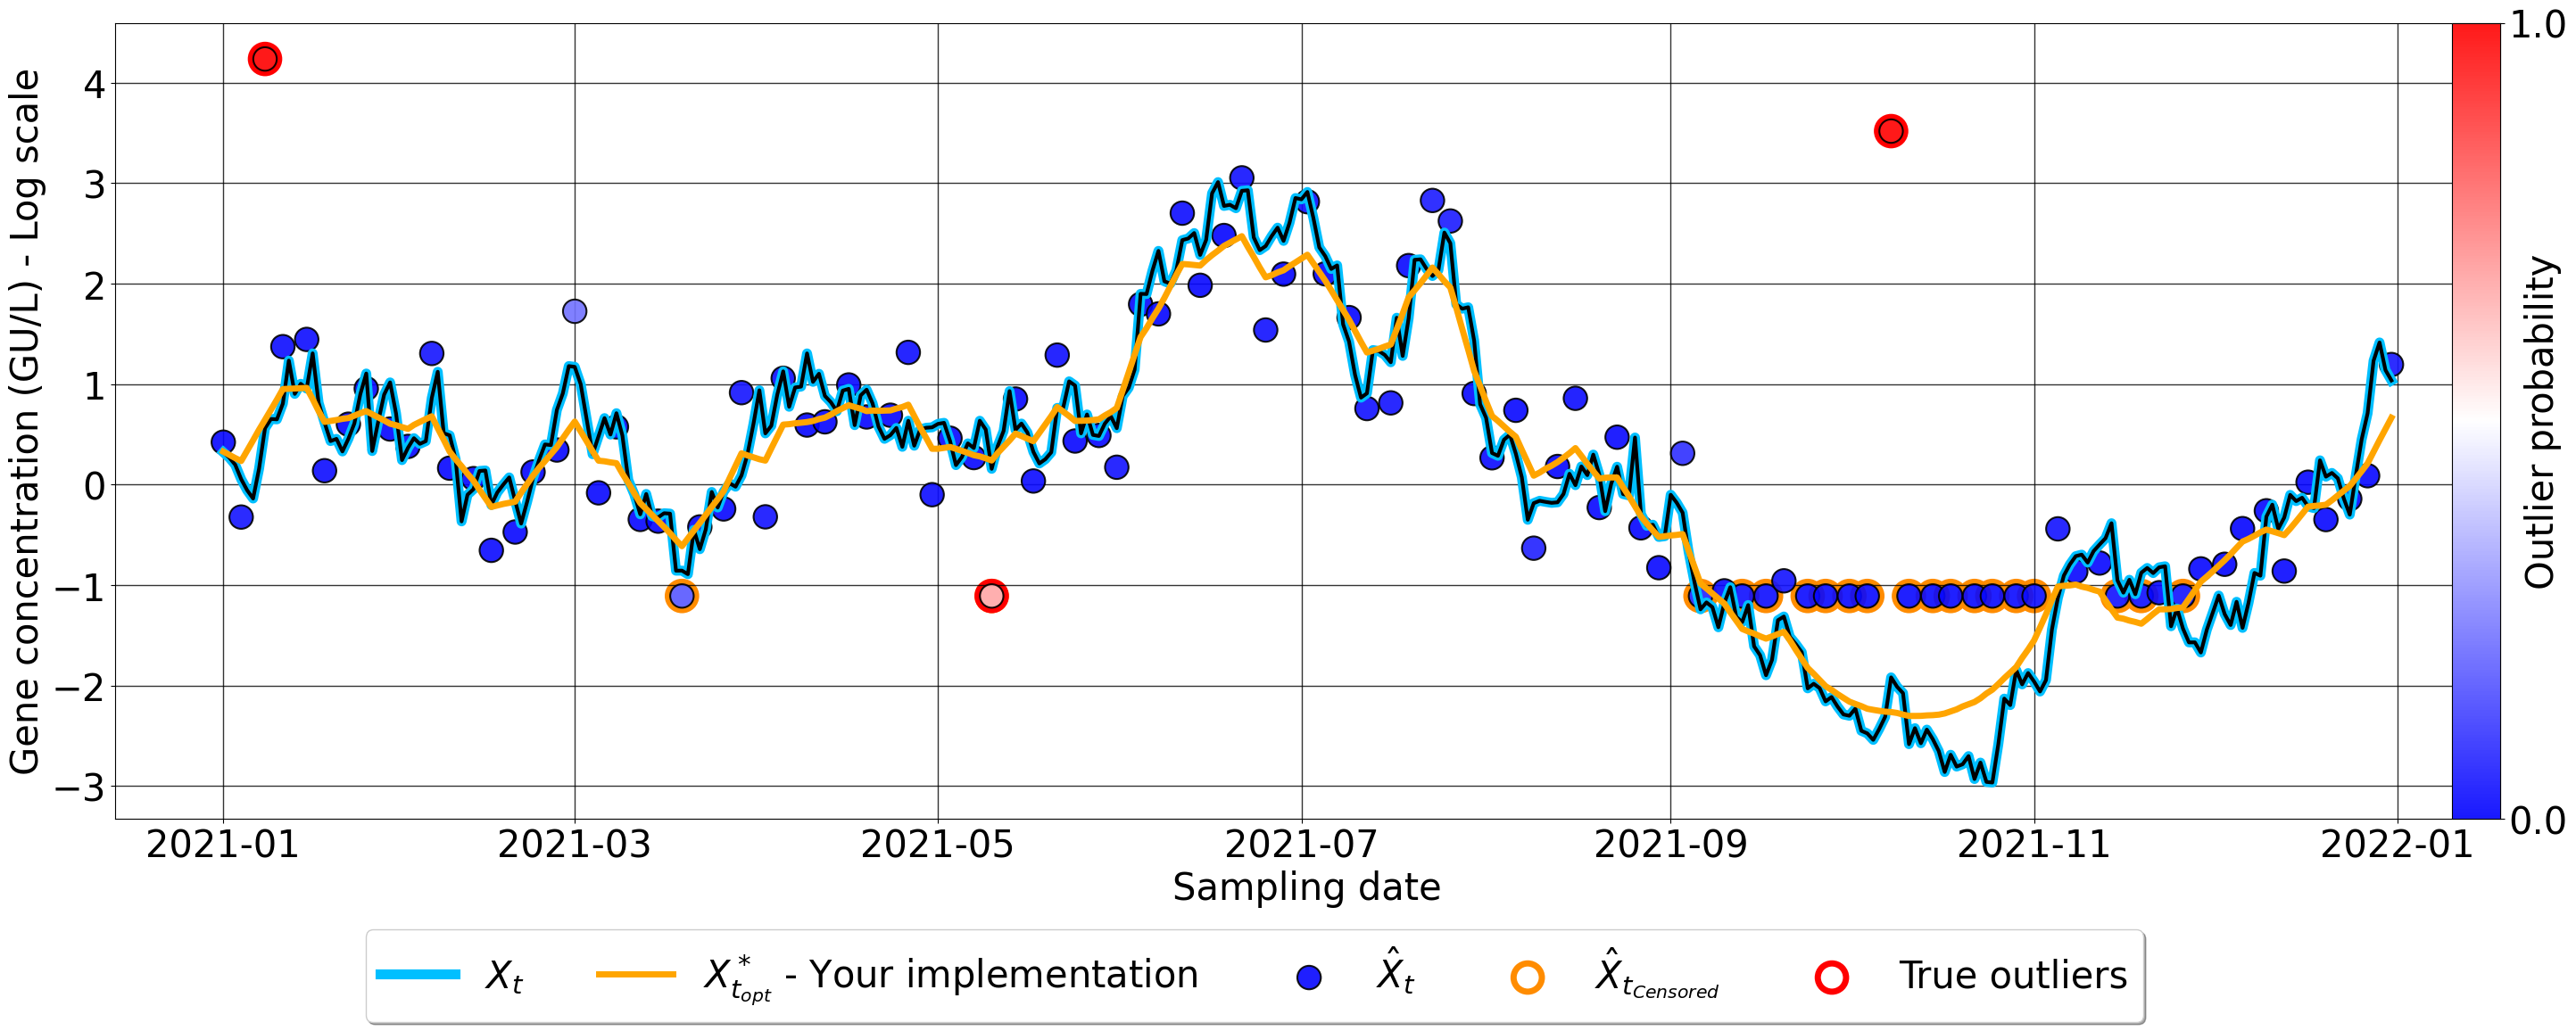

In [13]:
seed = 121
nb_states = 600

nb_chains = 3
tuning_iters = 4000
sampling_iters = 2000

gt_sig = 0.25
gt_eps = 0.4
gt_pout = 0.03

df, outliers_indexes, thresh = generate_data(seed=seed, gt_sig=gt_sig, gt_eps=gt_eps, gt_pOut_g=gt_pout)

lod_vect = np.ones(df.shape[0]) * thresh
observation_vect = df.Yt.values
 
t0 = time.time()
scou = SCOU(observation_vect, lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()
selected_chains = np.arange(nb_chains)
scou.predict(selected_chains)
scou.compute_pointwise_outlier_probabilities(selected_chains)

estimated_sig = scou.SCOU_traces['posterior']['sig'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_eps = scou.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_p_out = scou.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()

t1 = time.time()

print("Computation took " + str(t1 - t0) + "seconds.")
visualize_smoothed_data(df, outliers_indexes, scou, solution=None, visualize_solution=False)

In [14]:
print("Sigma :", gt_sig, estimated_sig)
print("Epsilon :", gt_eps, estimated_eps)
print("Pout :", gt_pout, estimated_p_out)

Sigma : 0.25 0.24137774759439454
Epsilon : 0.4 0.490754755263116
Pout : 0.03 0.06481294929039394


In [19]:
np.sqrt(mean_squared_error(scou.muX, df.Xt.values))

0.32397779245620256

**Question 2** : Comment ces valeurs évoluent avec une observation par jour ?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.249  0.028   0.197    0.301      0.001    0.001     608.0    1095.0   
eps    0.395  0.024   0.348    0.439      0.000    0.000    2650.0    3292.0   
p_out  0.022  0.009   0.006    0.037      0.000    0.000   10791.0    3587.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.249  0.028   0.197    0.301      0.001    0.001     608.0    1095.0   
eps    0.395  0.024   0.348    0.439      0.000    0.000    2650.0    3292.0   
p_out  0.022  0.009   0.006    0.037      0.000    0.000   10791.0    3587.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Computation took 36.86482834815979seconds.


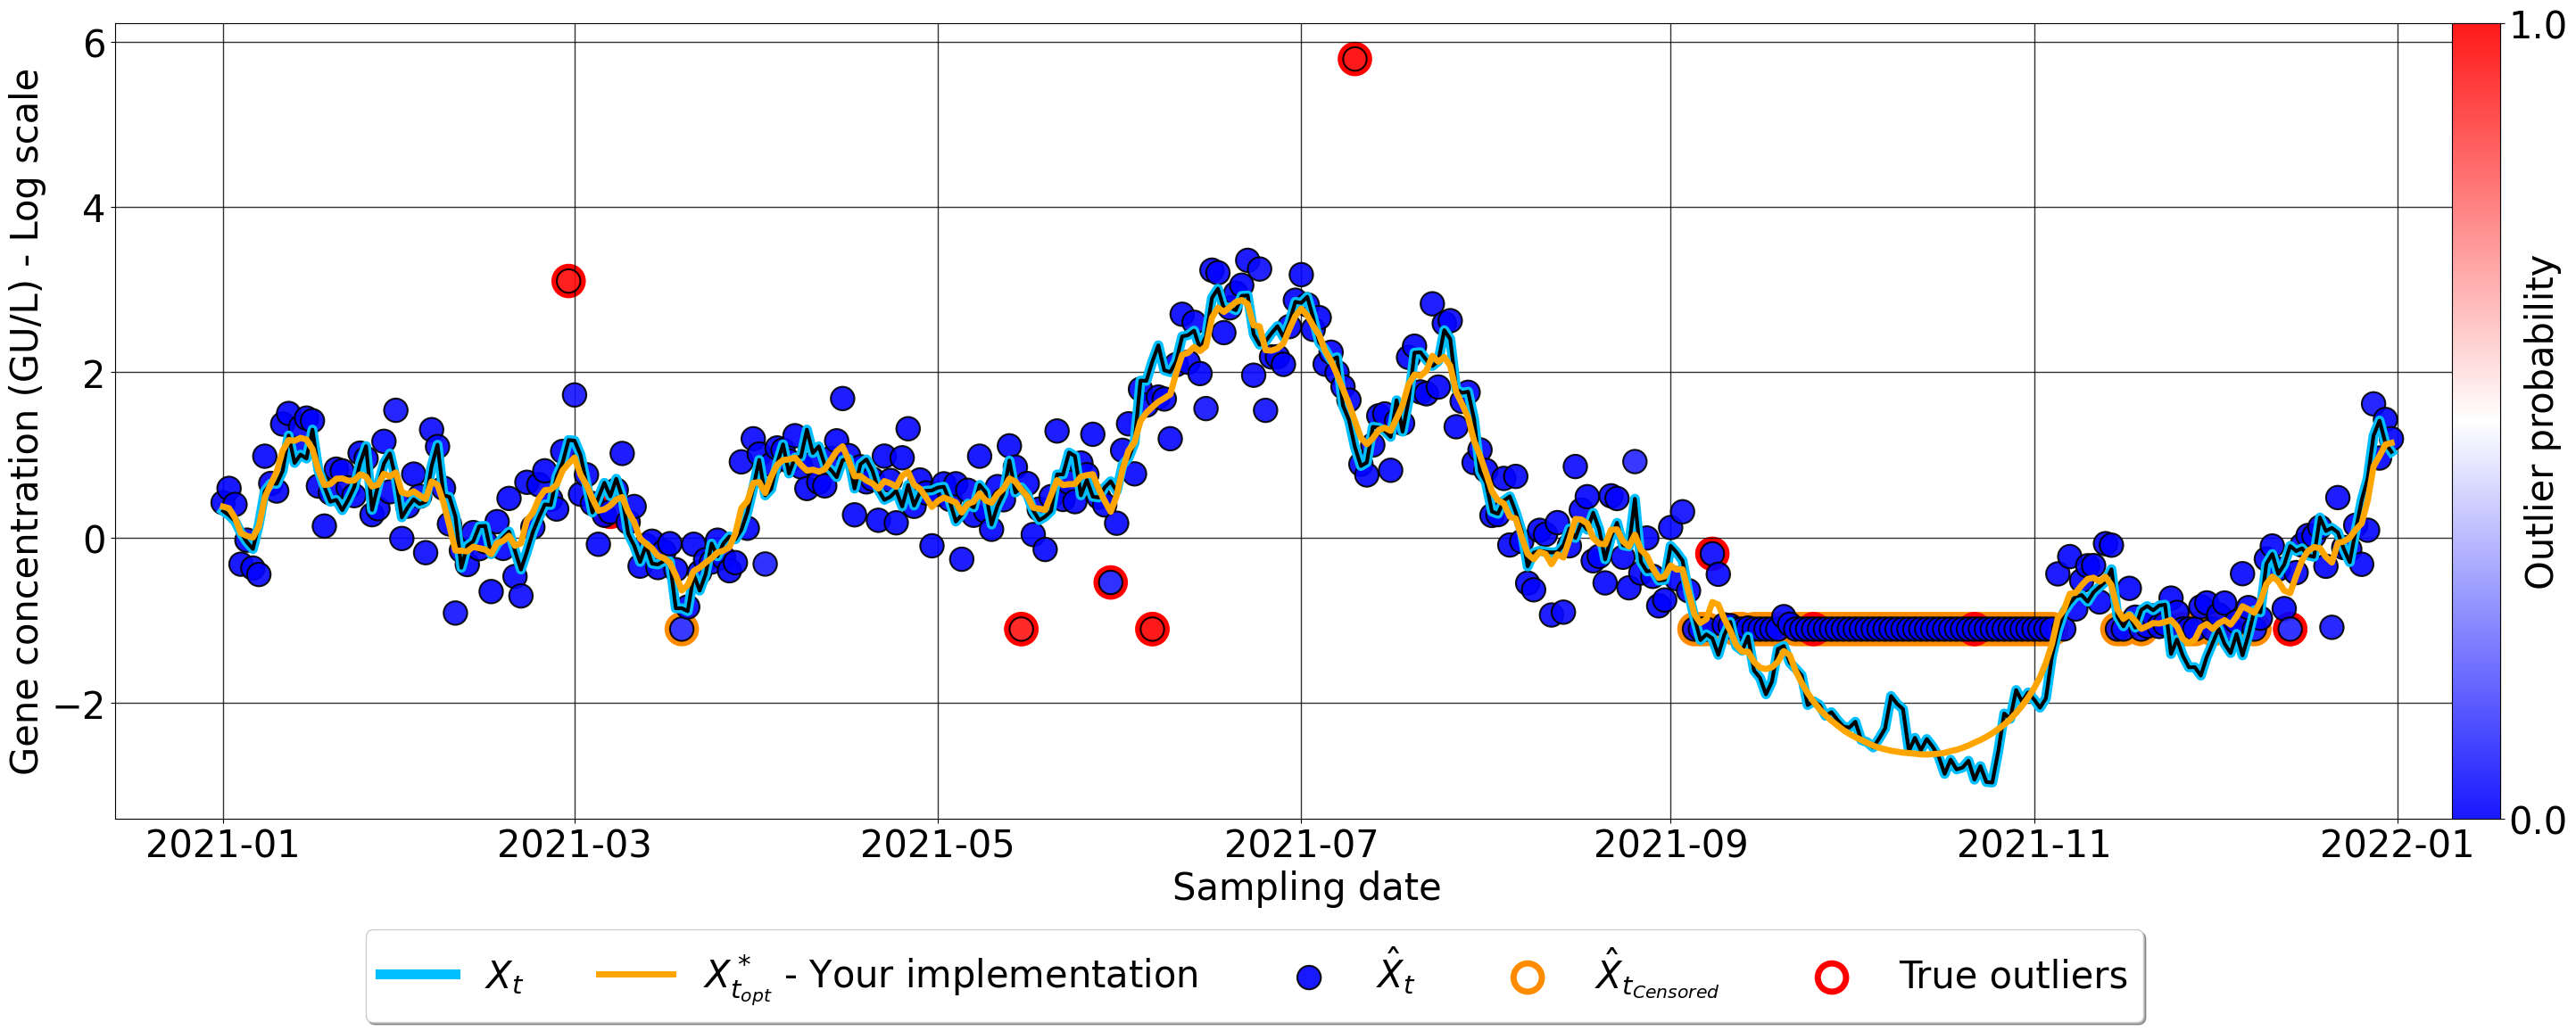

In [31]:
seed = 121
nb_states = 600

nb_chains = 3
tuning_iters = 4000
sampling_iters = 2000

gt_sig = 0.25
gt_eps = 0.4
gt_pout = 0.03

df, outliers_indexes, thresh = generate_data(seed=seed, gt_sig=gt_sig, gt_eps=gt_eps, gt_pOut_g=gt_pout, discard_those=[])

lod_vect = np.ones(df.shape[0]) * thresh
observation_vect = df.Yt.values
 
t0 = time.time()
scou = SCOU(observation_vect, lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()
selected_chains = np.arange(nb_chains)
scou.predict(selected_chains)
scou.compute_pointwise_outlier_probabilities(selected_chains)

estimated_sig = scou.SCOU_traces['posterior']['sig'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_eps = scou.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_p_out = scou.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()

t1 = time.time()

print("Computation took " + str(t1 - t0) + "seconds.")
visualize_smoothed_data(df, outliers_indexes, scou, solution=None, visualize_solution=False)

In [32]:
print("Sigma :", gt_sig, estimated_sig)
print("Epsilon :", gt_eps, estimated_eps)
print("Pout :", gt_pout, estimated_p_out)

Sigma : 0.25 0.2487802576114234
Epsilon : 0.4 0.39458622917362496
Pout : 0.03 0.021503951432082773


In [33]:
print("RMSE :", np.sqrt(mean_squared_error(scou.muX, df.Xt.values)))

RMSE : 0.21910650983080884


**Question 3** : Utiliser le code suivant pour tracer les courbes d'évolution de l'erreur en fonction du nombre d'échantillons utilisés :

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 65 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.271  0.062   0.156    0.383      0.007    0.005      67.0     103.0   
eps    0.436  0.150   0.160    0.709      0.009    0.006     277.0    1468.0   
p_out  0.079  0.046   0.006    0.162      0.001    0.001    3014.0    3664.0   

       r_hat  
sig     1.06  
eps     1.02  
p_out   1.00  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.271  0.062   0.156    0.383      0.007    0.005      67.0     103.0   
eps    0.436  0.150   0.160    0.709      0.009    0.006     277.0    1468.0   
p_out  0.079  0.046   0.006    0.162      0.001    0.001    3014.0    3664.0   

       r_hat  
sig     1.06  
eps     1.02  
p_out   1.00  
Computation took 69.94598007202148seconds.


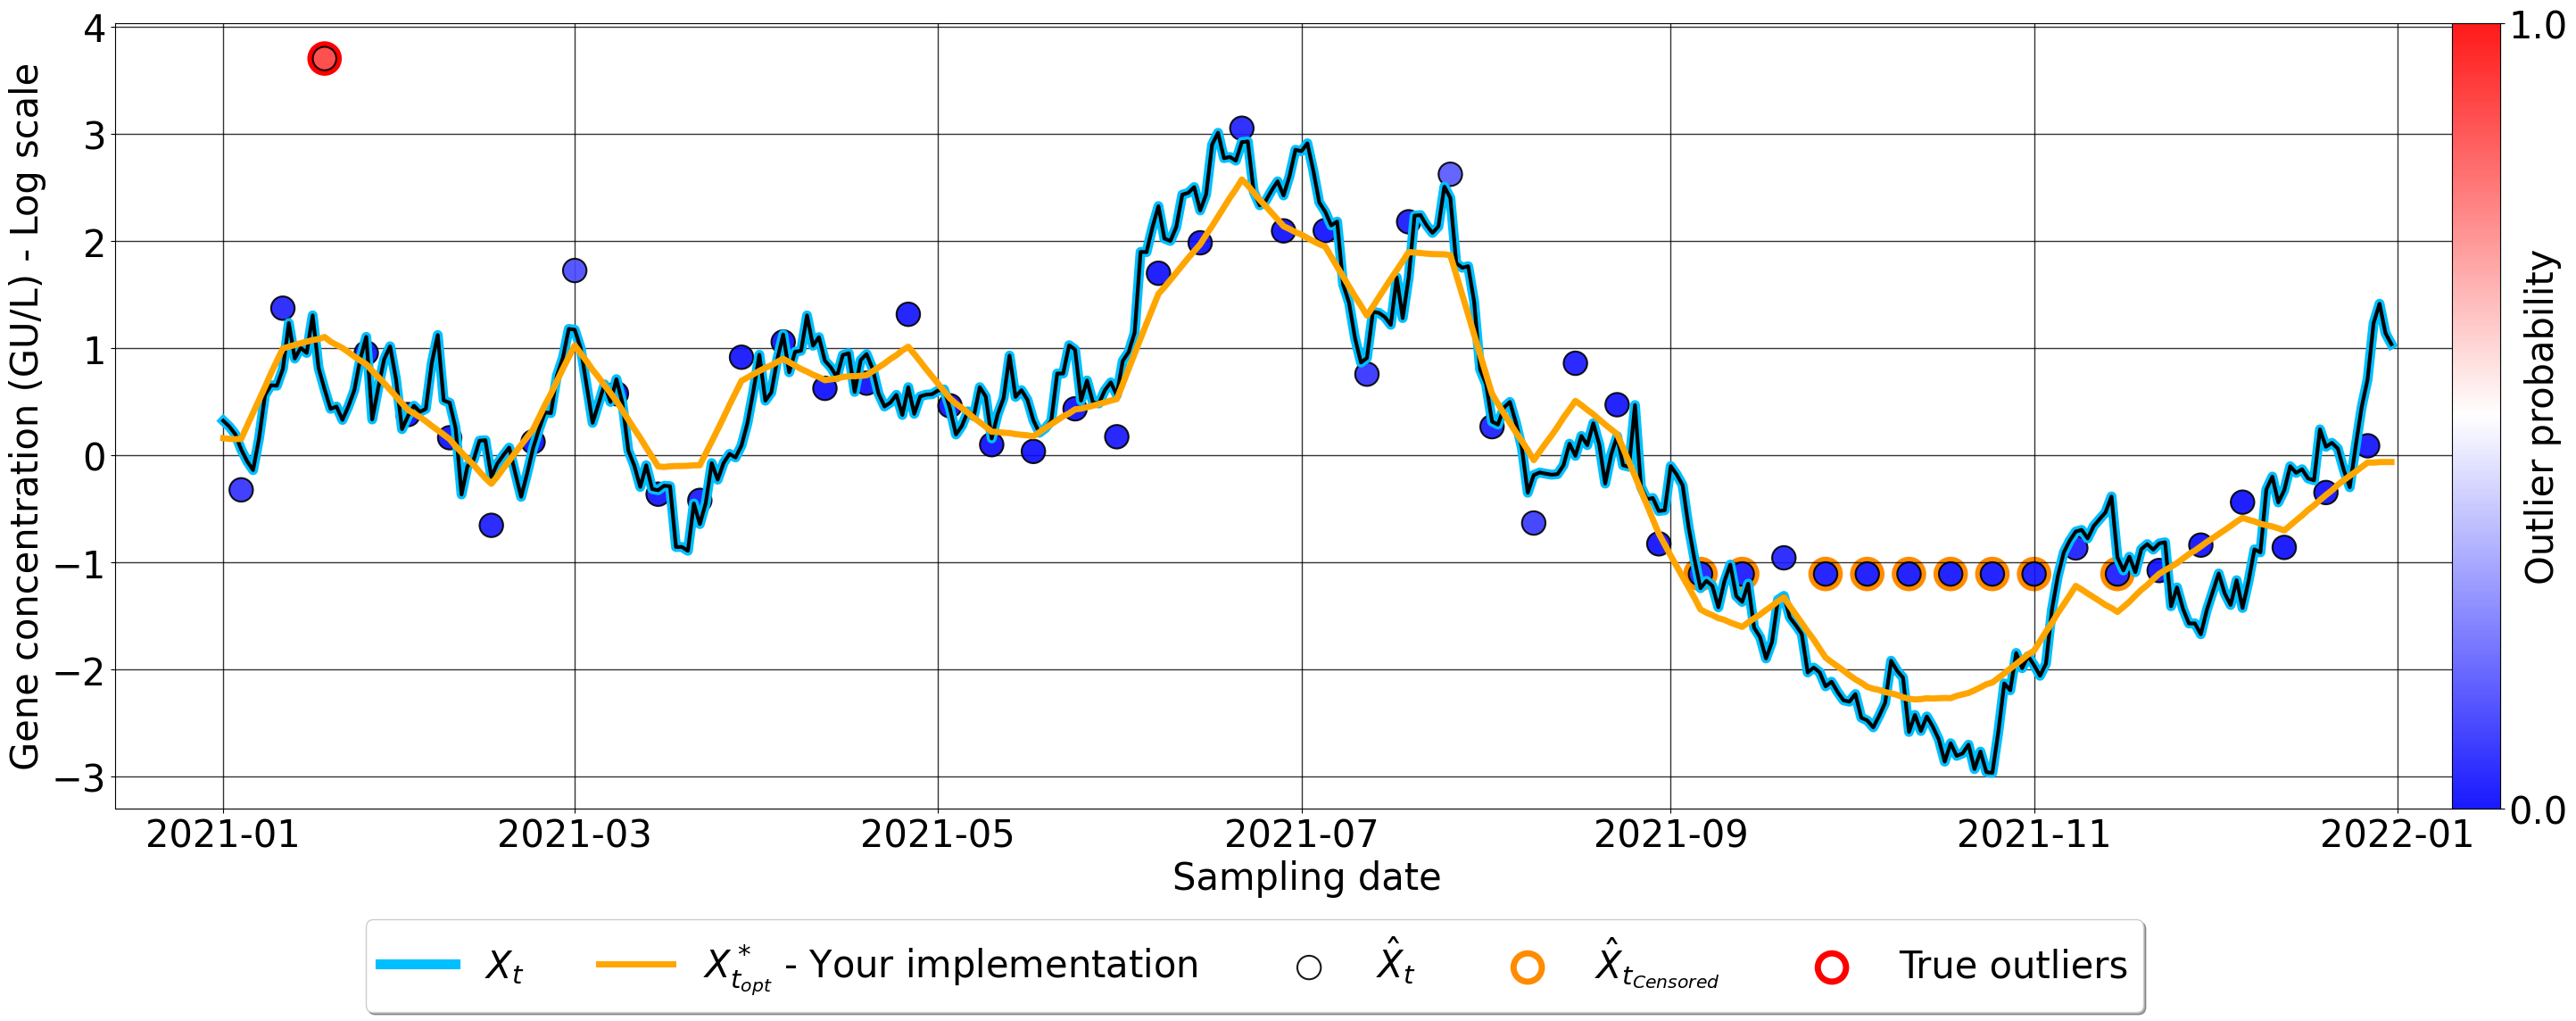

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.241  0.044   0.163    0.323      0.003    0.002     166.0     428.0   
eps    0.491  0.075   0.348    0.630      0.003    0.002     617.0    1087.0   
p_out  0.065  0.030   0.016    0.124      0.000    0.000    6532.0    4169.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.241  0.044   0.163    0.323      0.003    0.002     166.0     428.0   
eps    0.491  0.075   0.348    0.630      0.003    0.002     617.0    1087.0   
p_out  0.065  0.030   0.016    0.124      0.000    0.000    6532.0    4169.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Computation took 54.850441217422485seconds.


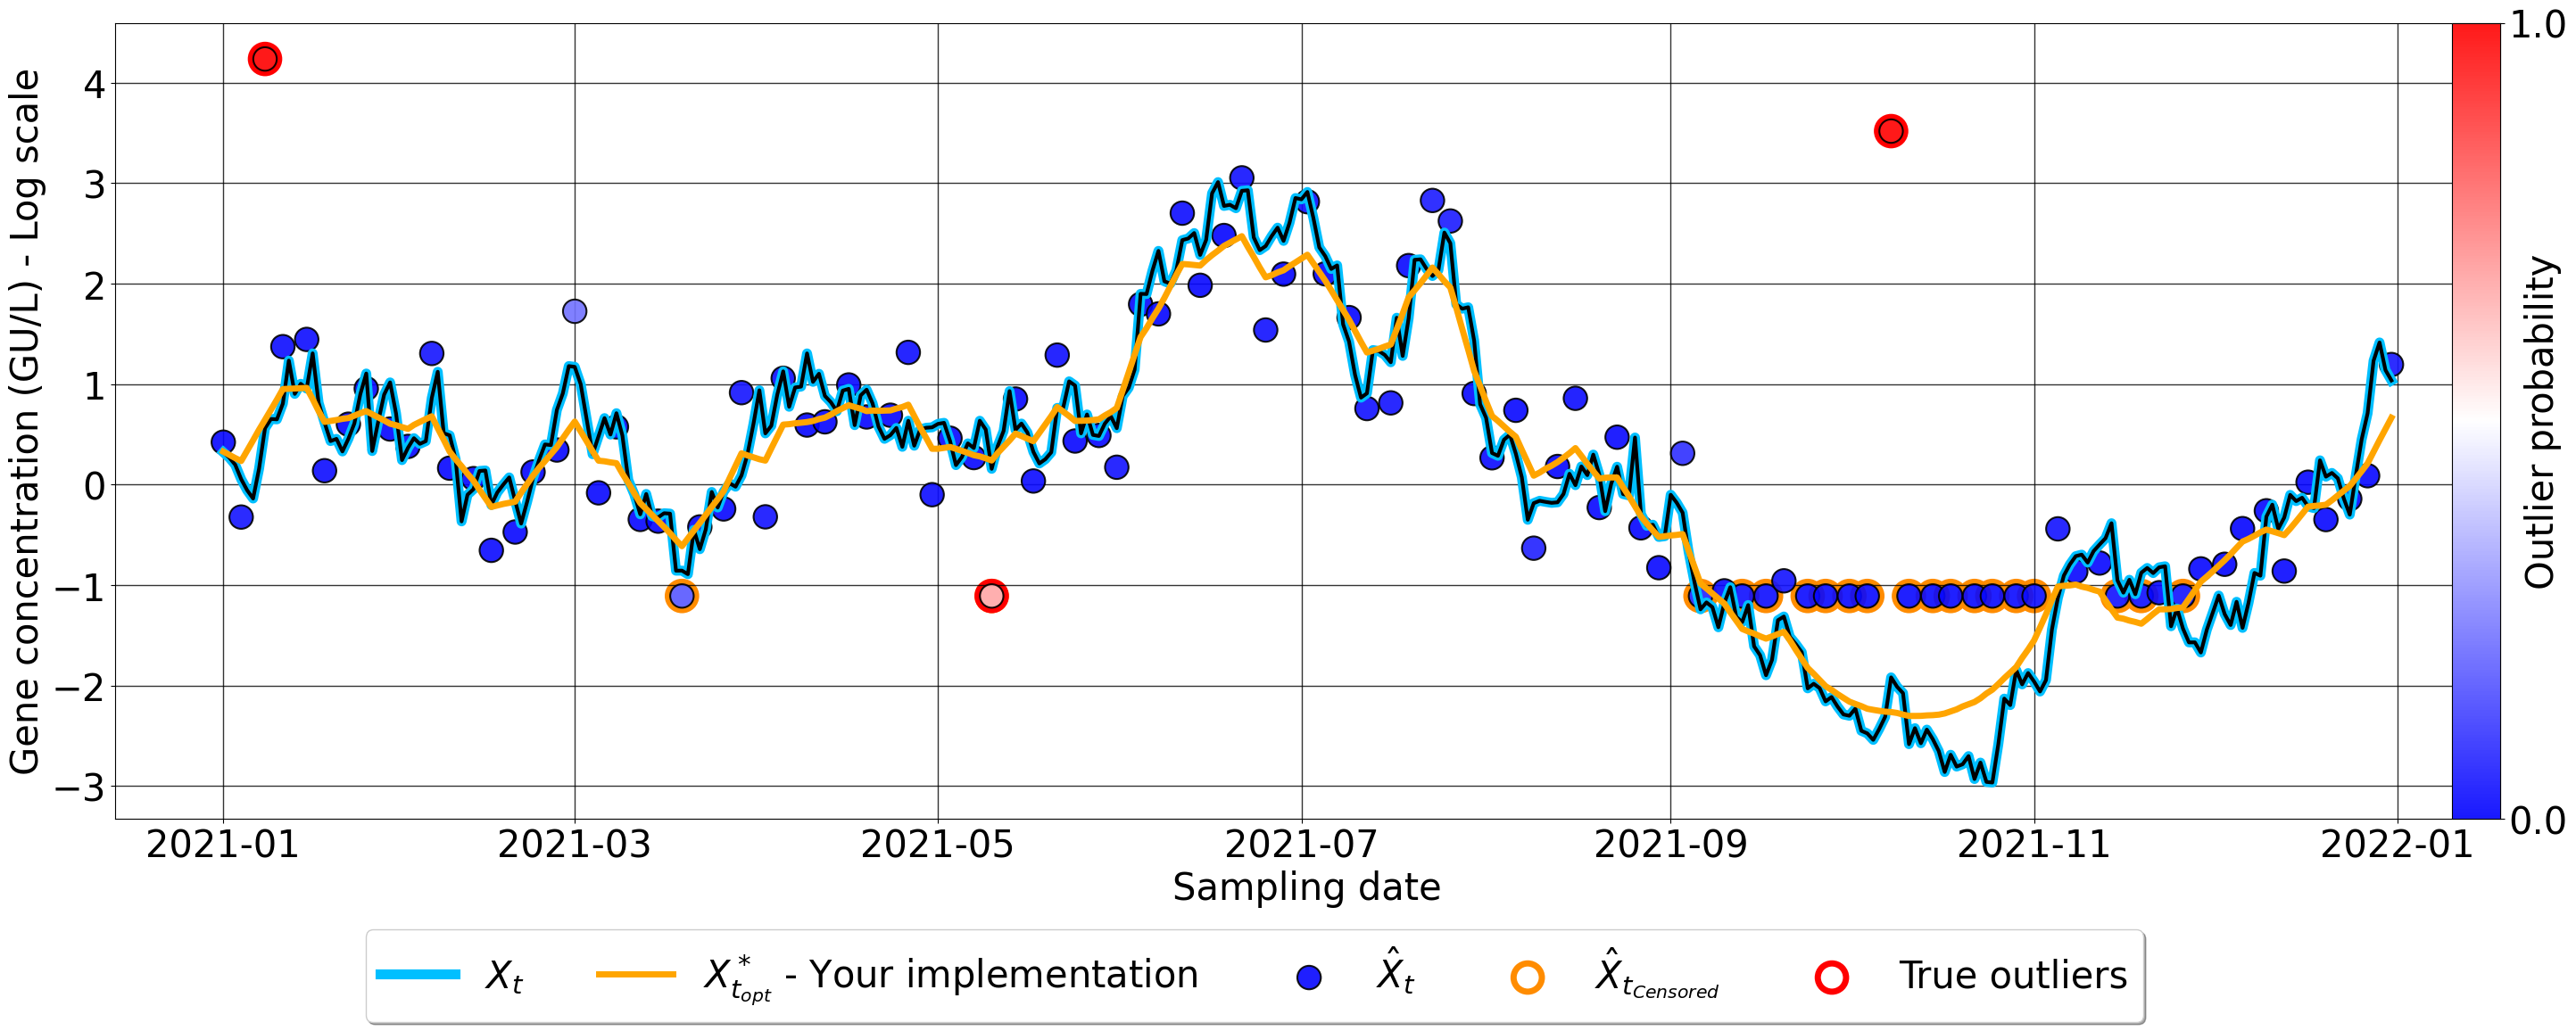

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.272  0.043   0.194    0.352      0.003    0.002     252.0     469.0   
eps    0.369  0.066   0.240    0.485      0.003    0.002     511.0     825.0   
p_out  0.049  0.021   0.013    0.088      0.000    0.000    5057.0    4205.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.272  0.043   0.194    0.352      0.003    0.002     252.0     469.0   
eps    0.369  0.066   0.240    0.485      0.003    0.002     511.0     825.0   
p_out  0.049  0.021   0.013    0.088      0.000    0.000    5057.0    4205.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Computation took 45.55252003669739seconds.


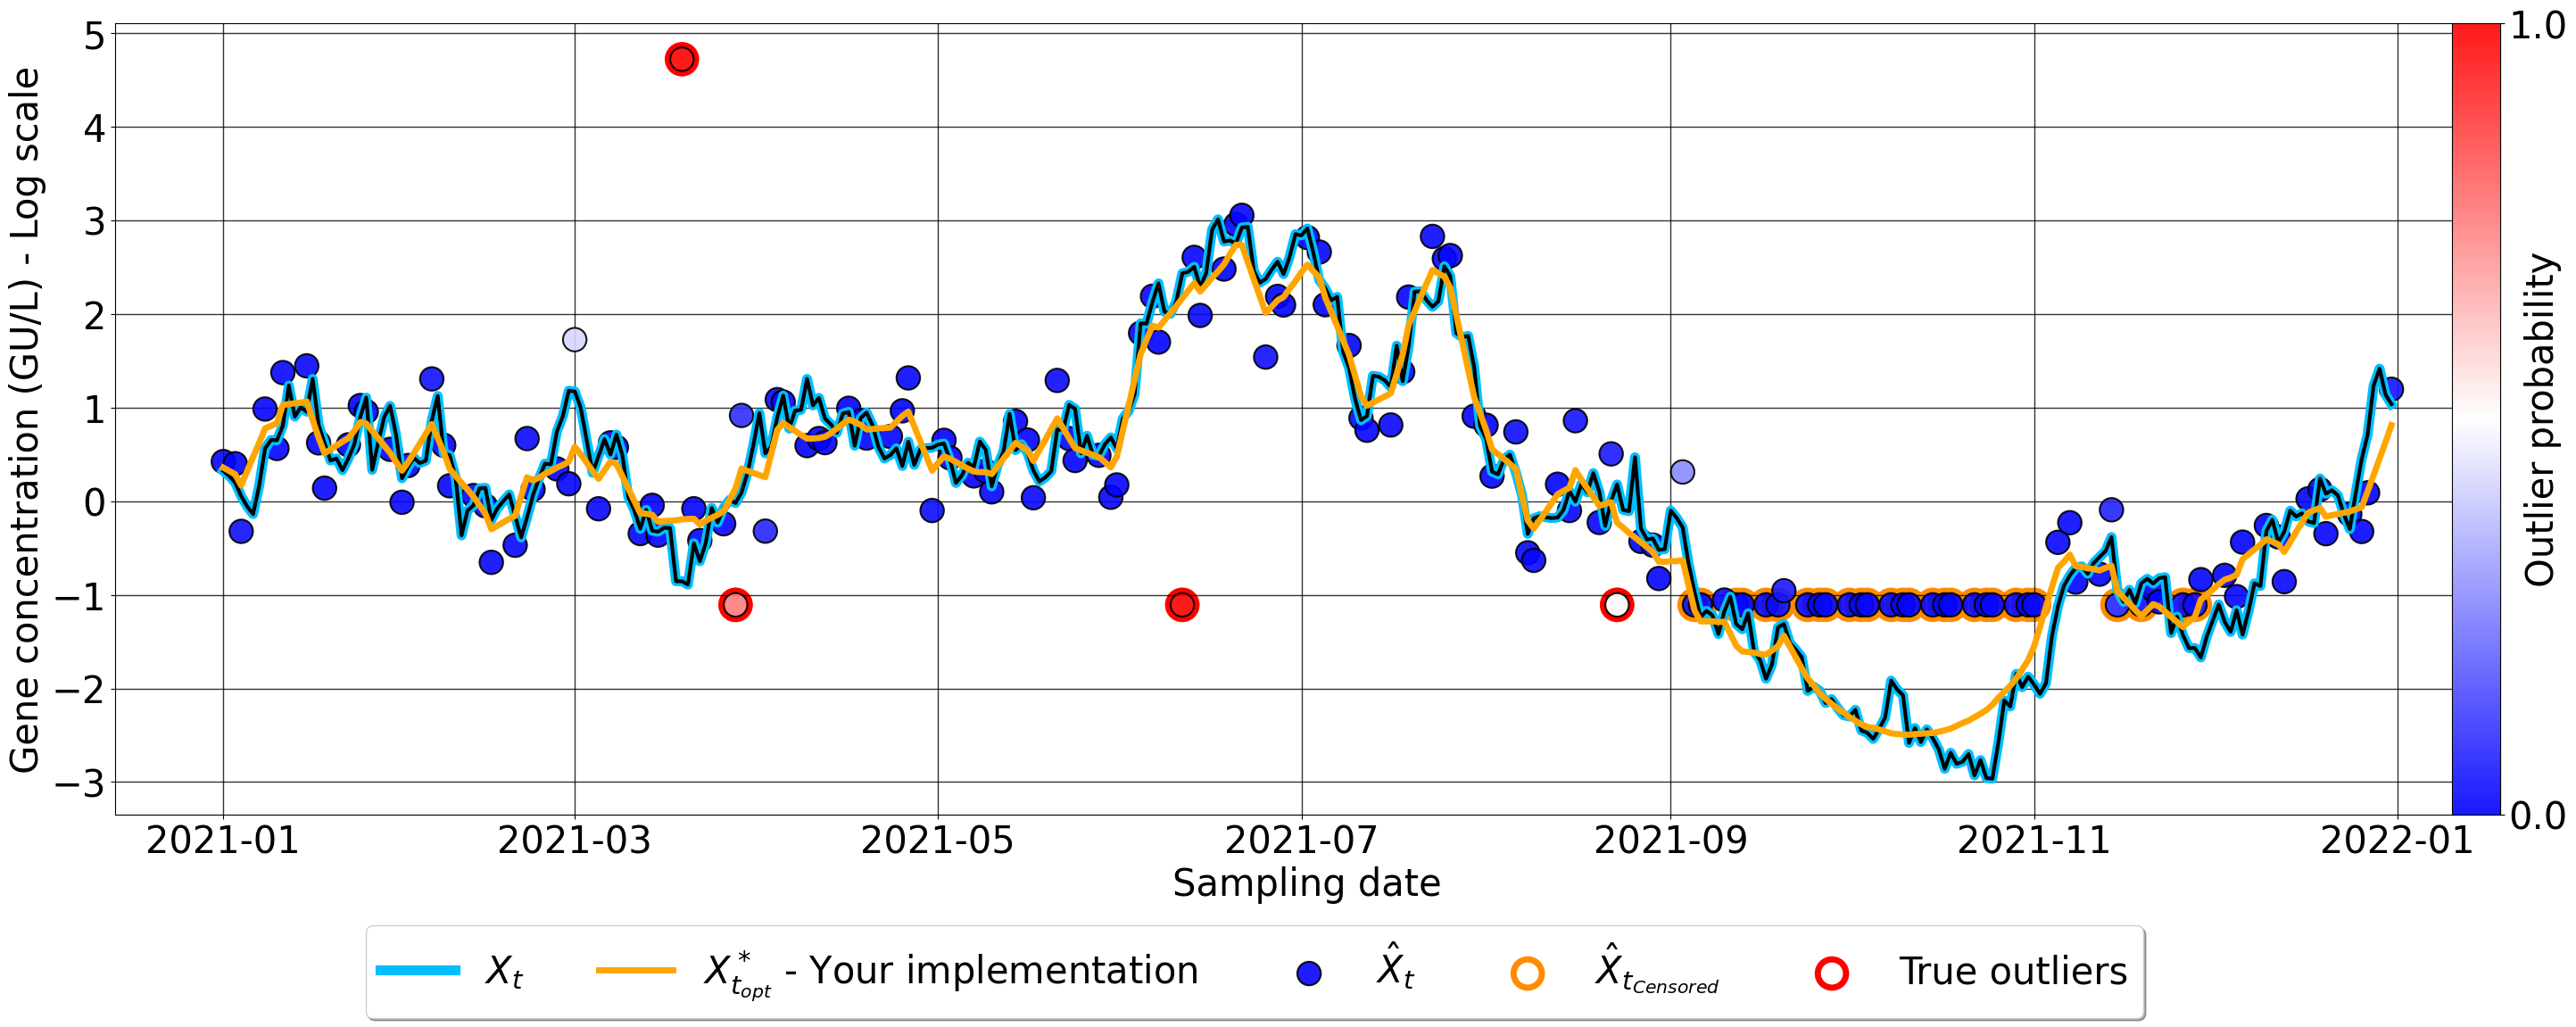

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.254  0.035   0.190    0.320      0.002    0.001     290.0     817.0   
eps    0.400  0.042   0.321    0.478      0.001    0.001    1199.0    2855.0   
p_out  0.034  0.016   0.007    0.063      0.000    0.000    6339.0    3840.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.254  0.035   0.190    0.320      0.002    0.001     290.0     817.0   
eps    0.400  0.042   0.321    0.478      0.001    0.001    1199.0    2855.0   
p_out  0.034  0.016   0.007    0.063      0.000    0.000    6339.0    3840.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Computation took 40.44508075714111seconds.


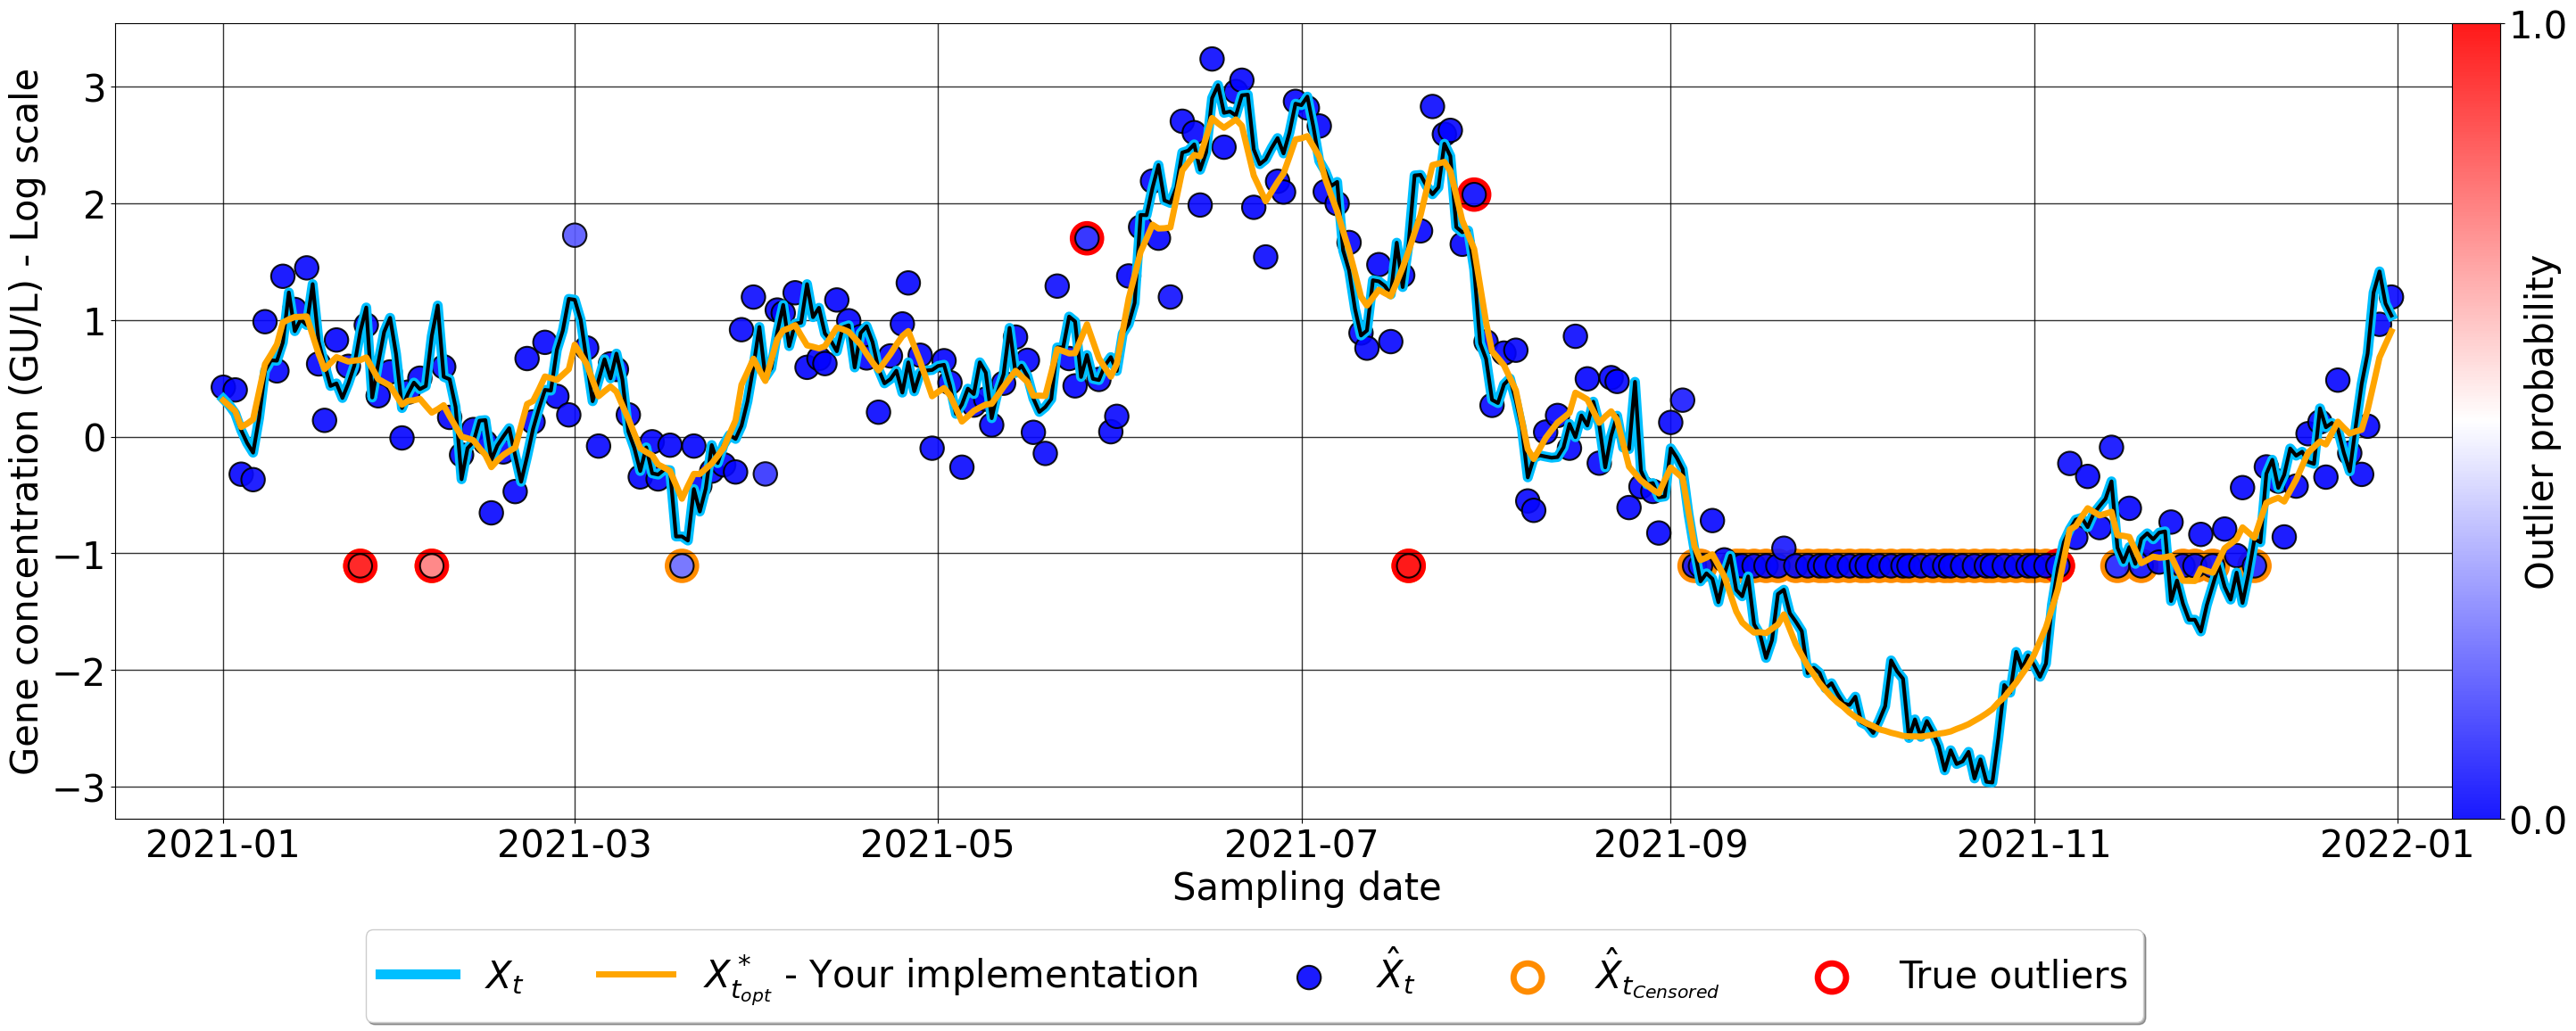

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 34 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.253  0.032   0.199    0.316      0.002    0.001     365.0     789.0   
eps    0.394  0.033   0.334    0.459      0.001    0.000    2274.0    3968.0   
p_out  0.041  0.014   0.016    0.069      0.000    0.000    7929.0    4492.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.253  0.032   0.199    0.316      0.002    0.001     365.0     789.0   
eps    0.394  0.033   0.334    0.459      0.001    0.000    2274.0    3968.0   
p_out  0.041  0.014   0.016    0.069      0.000    0.000    7929.0    4492.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Computation took 39.36033821105957seconds.


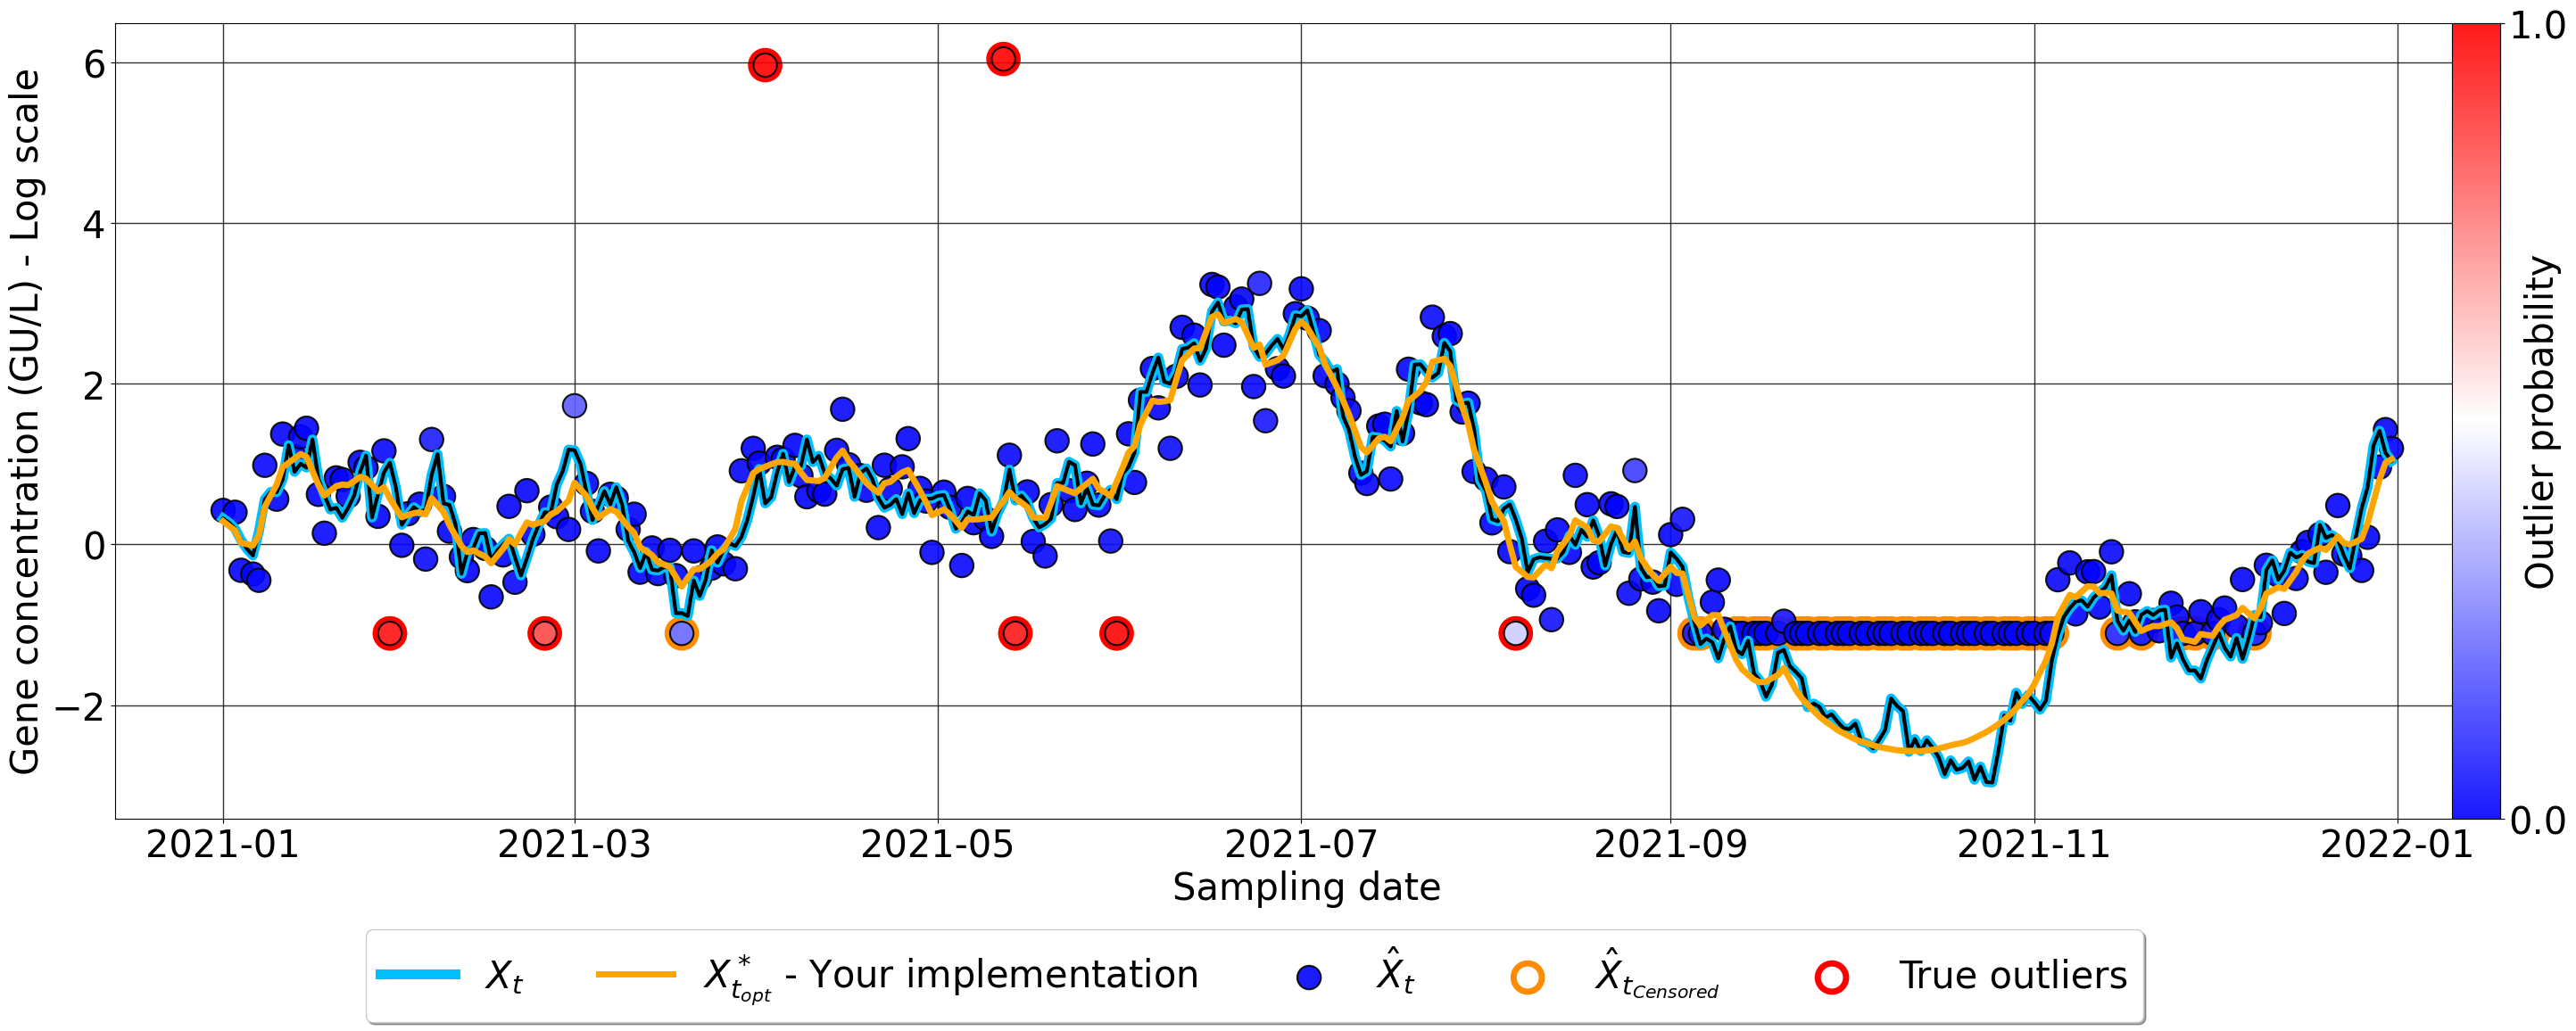

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 33 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.260  0.030   0.206    0.318      0.001    0.001     484.0     897.0   
eps    0.380  0.028   0.328    0.433      0.001    0.000    2456.0    3715.0   
p_out  0.033  0.012   0.013    0.055      0.000    0.000    9186.0    4000.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.260  0.030   0.206    0.318      0.001    0.001     484.0     897.0   
eps    0.380  0.028   0.328    0.433      0.001    0.000    2456.0    3715.0   
p_out  0.033  0.012   0.013    0.055      0.000    0.000    9186.0    4000.0   

       r_hat  
sig     1.01  
eps     1.00  
p_out   1.00  
Computation took 41.58302092552185seconds.


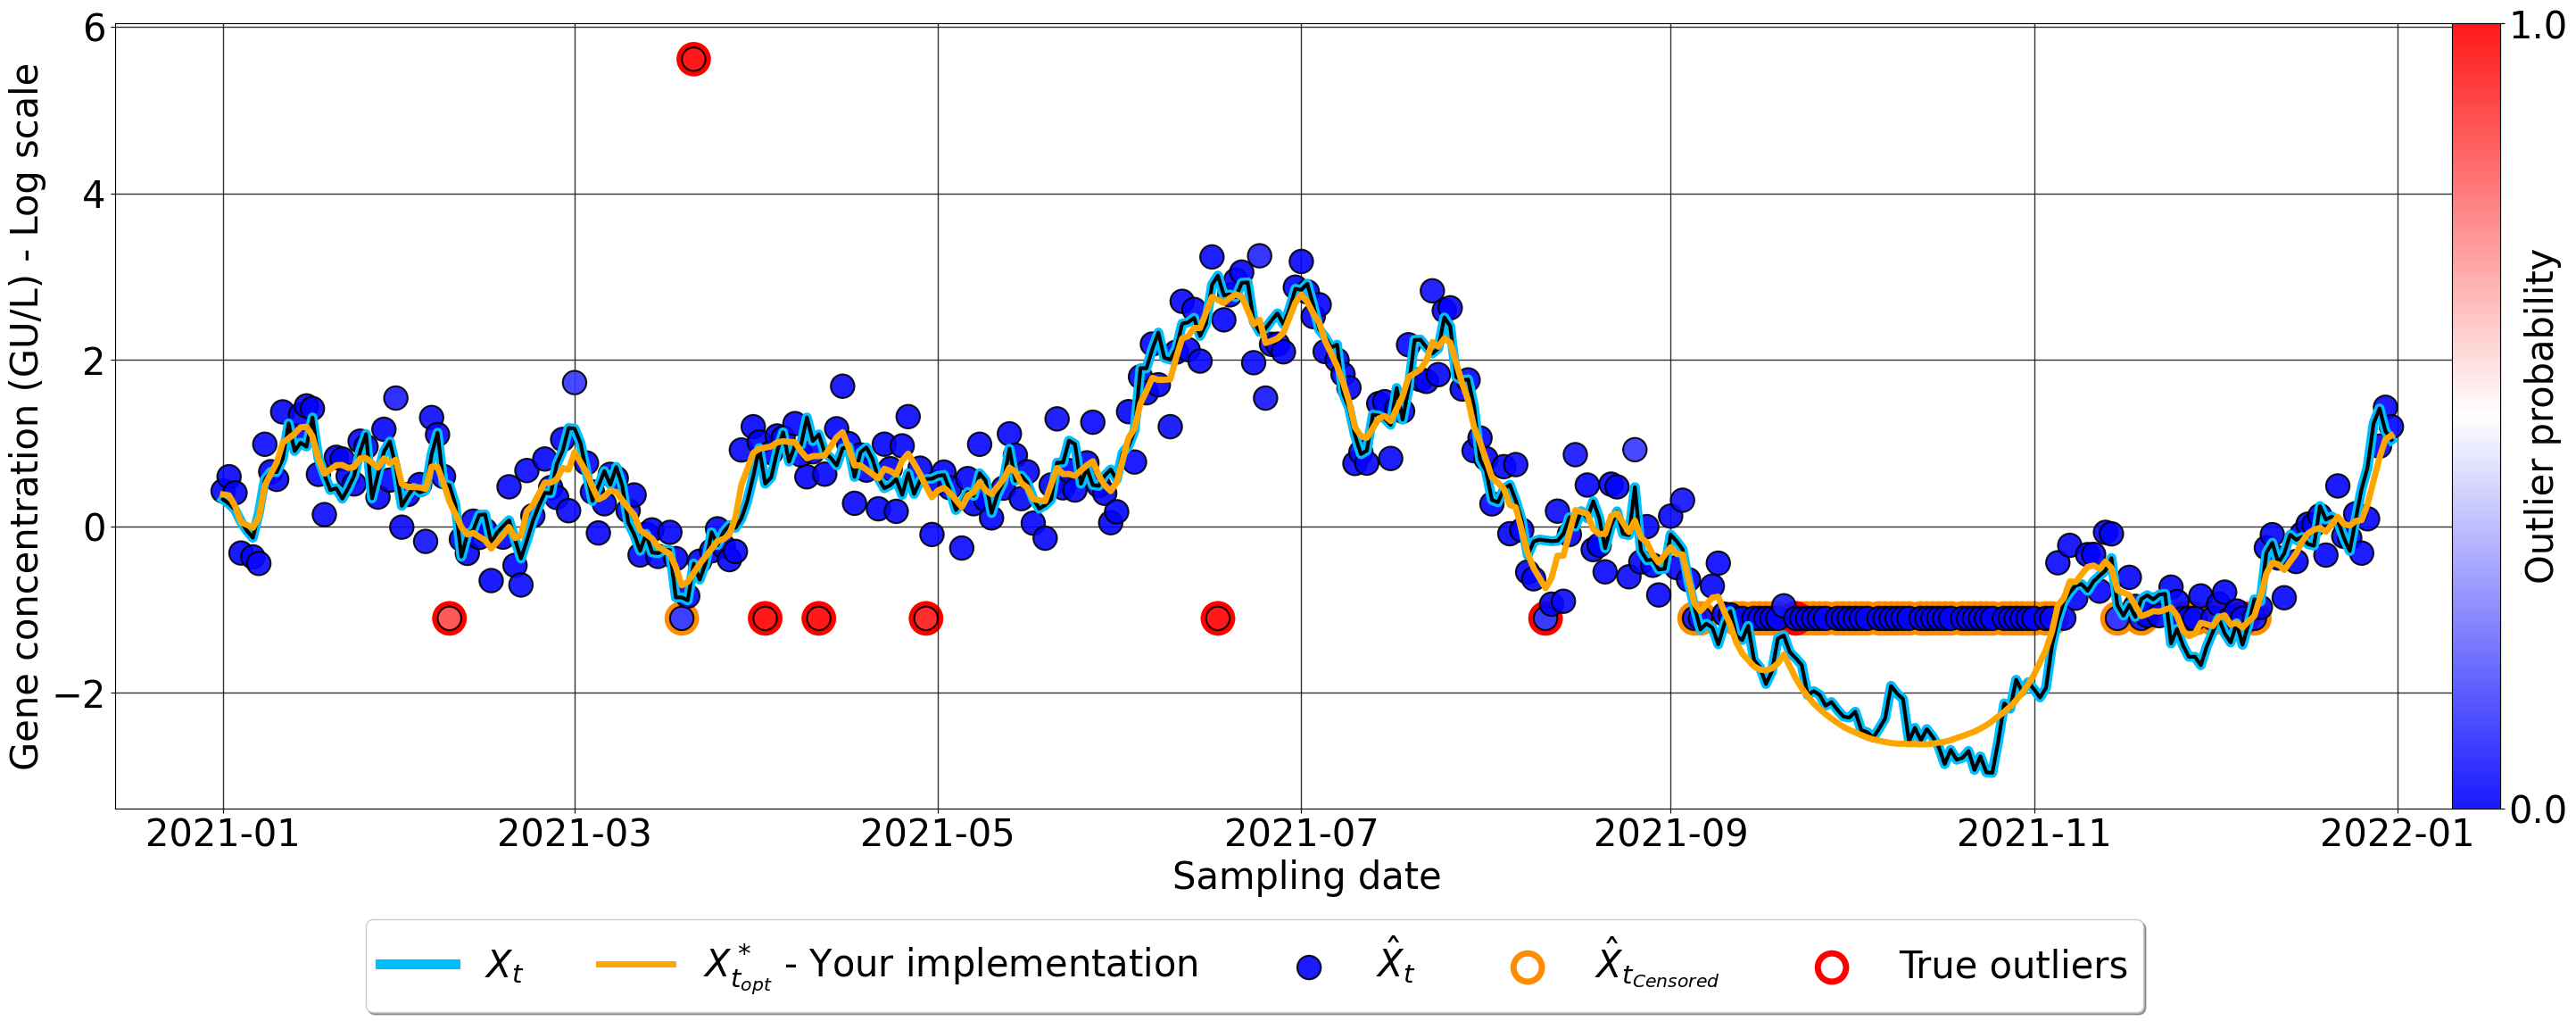

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.249  0.028   0.197    0.301      0.001    0.001     608.0    1095.0   
eps    0.395  0.024   0.348    0.439      0.000    0.000    2650.0    3292.0   
p_out  0.022  0.009   0.006    0.037      0.000    0.000   10791.0    3587.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.249  0.028   0.197    0.301      0.001    0.001     608.0    1095.0   
eps    0.395  0.024   0.348    0.439      0.000    0.000    2650.0    3292.0   
p_out  0.022  0.009   0.006    0.037      0.000    0.000   10791.0    3587.0   

       r_hat  
sig      1.0  
eps      1.0  
p_out    1.0  
Computation took 36.13683009147644seconds.


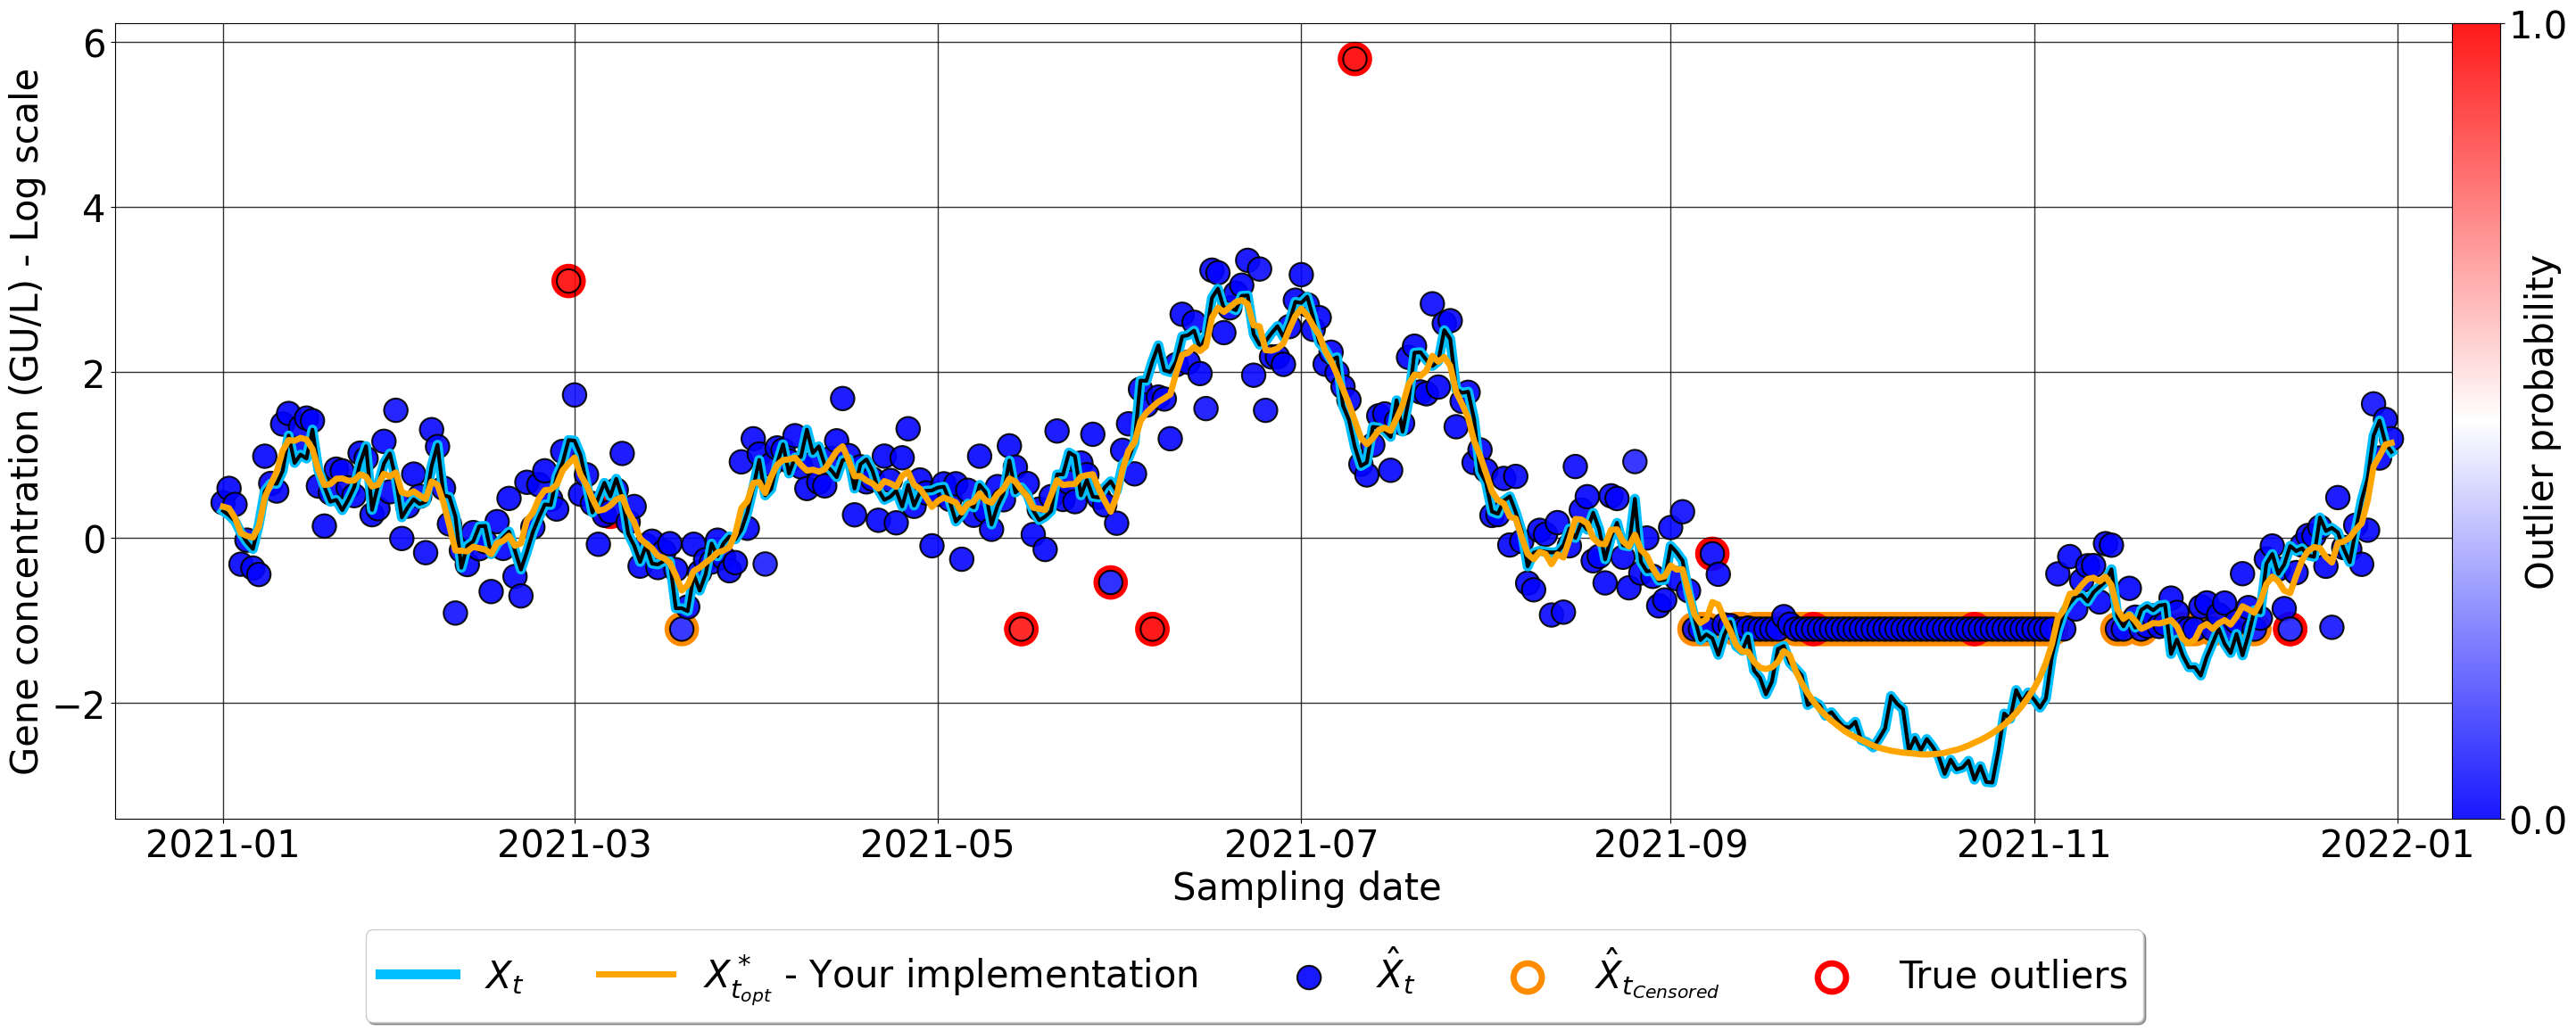

In [29]:
seed = 121
nb_states = 600

nb_chains = 3
tuning_iters = 4000
sampling_iters = 2000

gt_sig = 0.25
gt_eps = 0.4
gt_pout = 0.03

sigmas, epsilons, pouts, muXs = {}, {}, {}, {}

combinations = {}
combinations[1] = [1, 2, 3, 4, 5, 6] # 1 jour par semaine
combinations[2] = [1, 2, 3, 5, 6] # 2 jours par semaine
combinations[3] = [1, 2, 3, 5] # 3 jours par semaine
combinations[4] = [1, 3, 5] # 4 jours par semaine
combinations[5] = [1, 5] # 5 jours par semaine
combinations[6] = [1] # 6 jours par semaine
combinations[7] = [] # 7 jours par semaine

for combination in list(combinations.keys()):
    df, outliers_indexes, thresh = generate_data(seed=seed, gt_sig=gt_sig, gt_eps=gt_eps, gt_pOut_g=gt_pout, discard_those=combinations[combination])
    
    lod_vect = np.ones(df.shape[0]) * thresh
    observation_vect = df.Yt.values
     
    t0 = time.time()
    scou = SCOU(observation_vect, lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                                 export_name=None, 
                                 p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                                 RW_order=1)
    scou.fit()
    selected_chains = np.arange(nb_chains)
    scou.predict(selected_chains)
    scou.compute_pointwise_outlier_probabilities(selected_chains)
    
    estimated_sig = scou.SCOU_traces['posterior']['sig'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
    estimated_eps = scou.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
    estimated_p_out = scou.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()

    sigmas[combination] = estimated_sig
    epsilons[combination] = estimated_eps
    pouts[combination] = estimated_p_out
    muXs[combination] = scou.muX
    
    t1 = time.time()
    print("Computation took " + str(t1 - t0) + "seconds.")

    visualize_smoothed_data(df, outliers_indexes, scou, solution=None, visualize_solution=False)

In [26]:
sigmas

{1: 0.2713293399681683,
 2: 0.24137774759439454,
 3: 0.27186362542272047,
 4: 0.2541674988785209,
 5: 0.2534494165236801,
 6: 0.2597666086747186,
 7: 0.2487802576114234}

In [27]:
epsilons

{1: 0.43615360069083386,
 2: 0.490754755263116,
 3: 0.3685030372370722,
 4: 0.39996334449229837,
 5: 0.39427897432124404,
 6: 0.3801200833807437,
 7: 0.39458622917362496}

In [28]:
pouts

{1: 0.07921732387464776,
 2: 0.06481294929039394,
 3: 0.049114427007313756,
 4: 0.03393059080797755,
 5: 0.041210943256206764,
 6: 0.03296597240996597,
 7: 0.021503951432082773}

In [30]:
muXs

{1: array([ 0.16013782,  0.1541021 ,  0.15070478,  0.15337824,  0.27670112,
         0.39658638,  0.51713532,  0.63883191,  0.76583565,  0.88207711,
         0.9983901 ,  1.01380682,  1.03083608,  1.04649487,  1.06163004,
         1.07594254,  1.0852579 ,  1.1048865 ,  1.06123465,  1.03090655,
         1.00219224,  0.9634613 ,  0.92230584,  0.88525119,  0.85015269,
         0.78865701,  0.73090992,  0.674225  ,  0.61164721,  0.55003003,
         0.48494734,  0.42484229,  0.39087466,  0.35717428,  0.31833768,
         0.27462684,  0.2338083 ,  0.19337758,  0.15071823,  0.08547159,
         0.02612365, -0.03324537, -0.08817719, -0.15190007, -0.2132526 ,
        -0.26565915, -0.19912025, -0.12273306, -0.04828818,  0.02485521,
         0.09717263,  0.16919519,  0.24105241,  0.35394977,  0.46985756,
         0.57486736,  0.68989968,  0.80697134,  0.91755757,  1.02556059,
         0.95255746,  0.87832074,  0.79775763,  0.7296151 ,  0.65311403,
         0.58180328,  0.50603125,  0.42005028,  

In [ ]:
# Codez ici la cellule qui permet de tracer les erreurs sur sigma, epsilon, pout et muX en fonction du 
# nombre d'observations utilisées par le modèle
# ...

**Question 4** : Application à deux cas très particuliers : faible nombre d'échantillons (#$\mathcal{T} = 6$). Que se passe-t-il dans chacun de ces cas ? Commenter.

**Cas 1**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.397  0.192   0.169    0.739      0.028    0.020      23.0      16.0   
eps    0.446  0.358   0.091    0.914      0.030    0.021      45.0     660.0   
p_out  0.239  0.150   0.011    0.527      0.014    0.010     451.0     614.0   

       r_hat  
sig     1.09  
eps     1.05  
p_out   1.04  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.397  0.192   0.169    0.739      0.028    0.020      23.0      16.0   
eps    0.446  0.358   0.091    0.914      0.030    0.021      45.0     660.0   
p_out  0.239  0.150   0.011    0.527      0.014    0.010     451.0     614.0   

       r_hat  
sig     1.09  
eps     1.05  
p_out   1.04  
Computation took 58.62793803215027seconds.


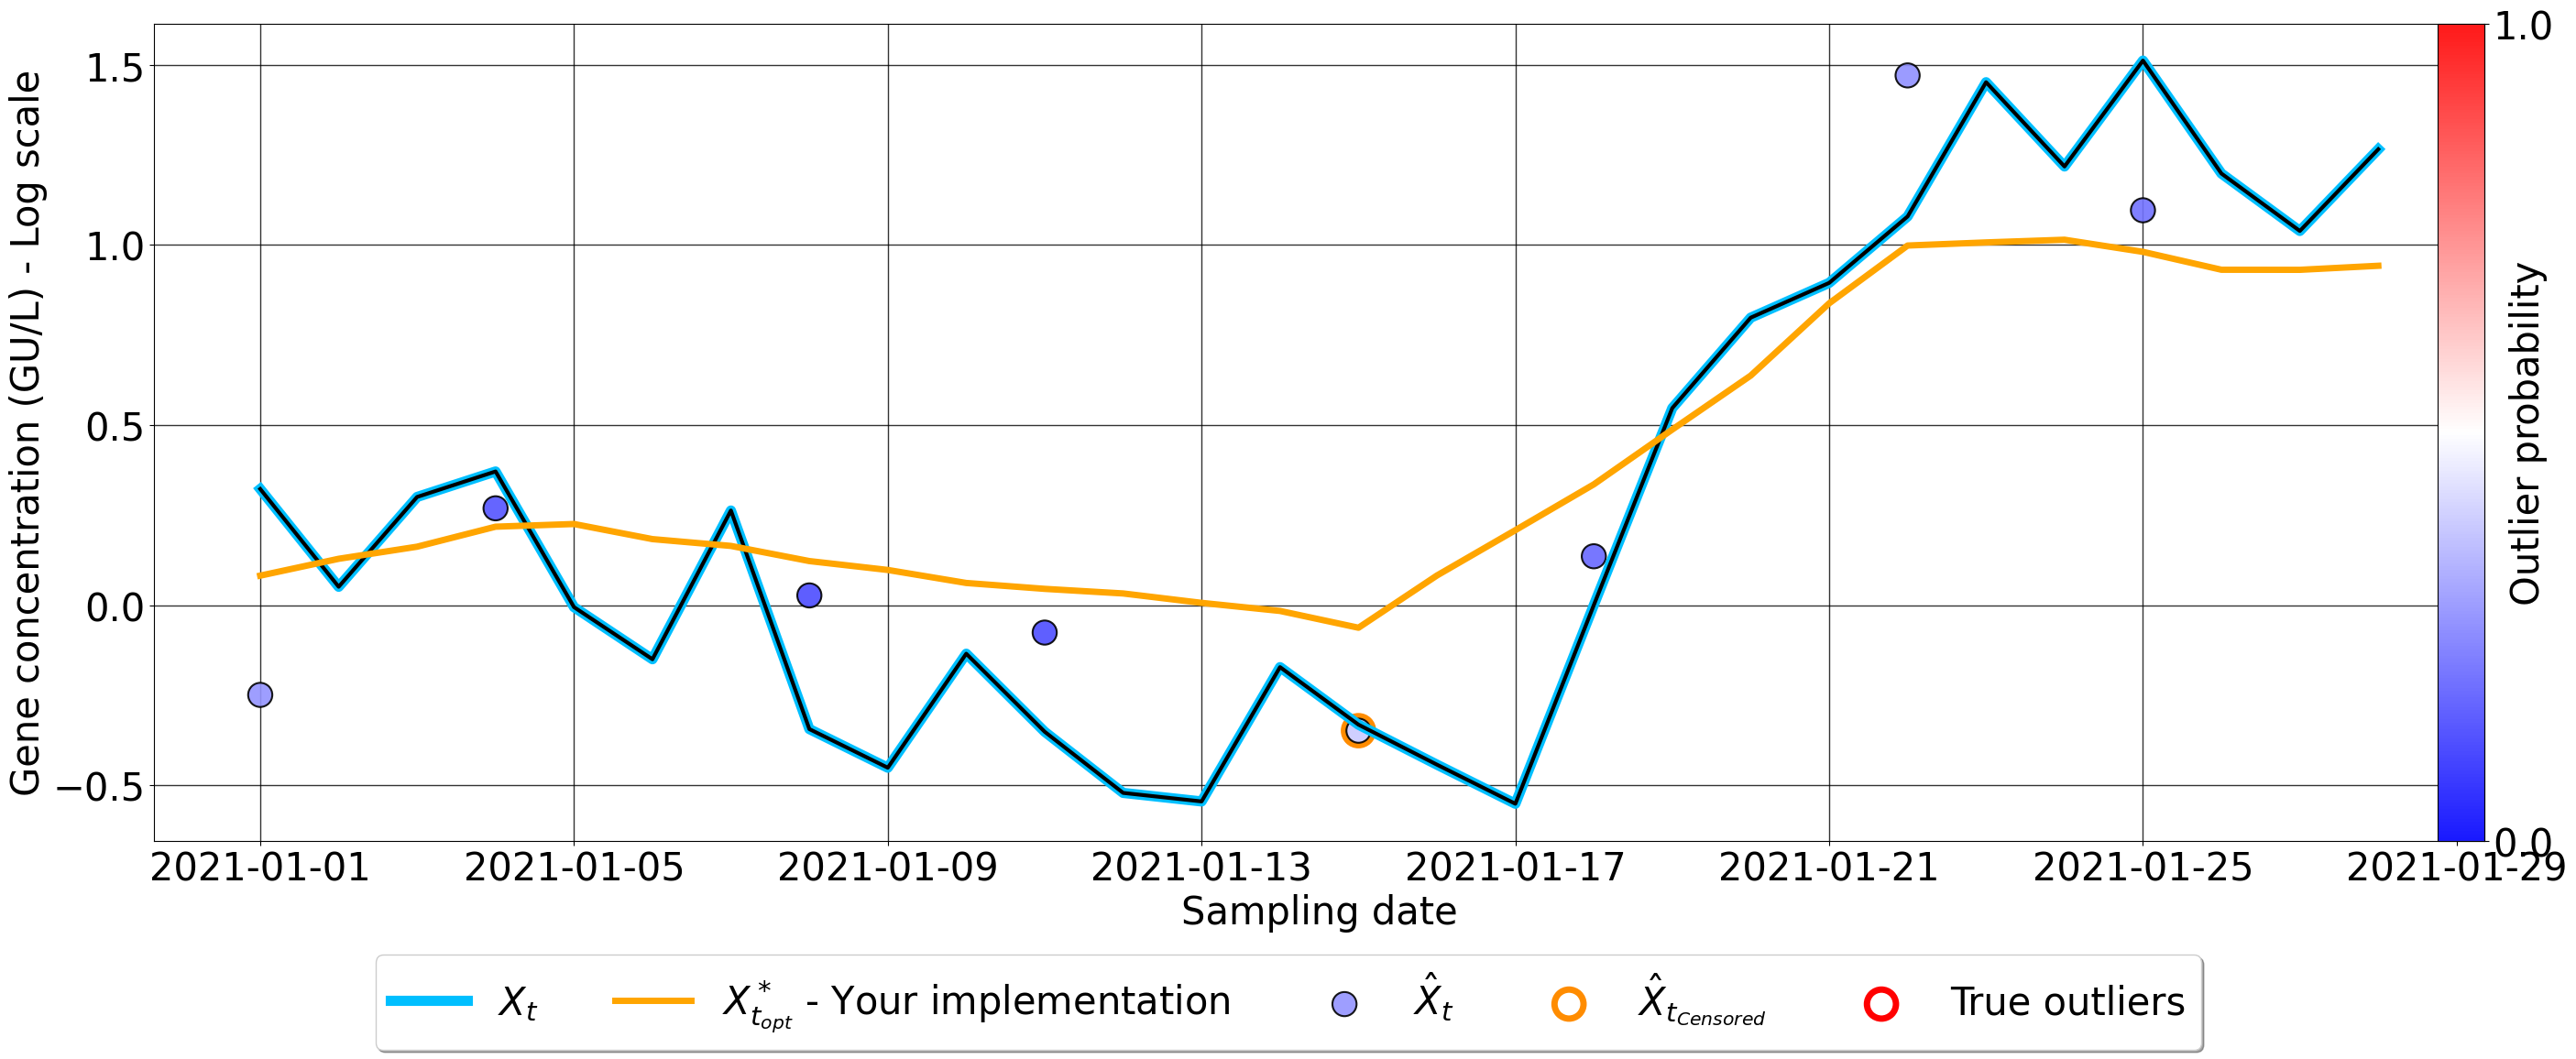

In [35]:
seed = 123
nb_states = 600

nb_chains = 3
tuning_iters = 4000
sampling_iters = 2000

gt_sig = 0.25
gt_eps = 0.4
gt_pout = 0.03

df, outliers_indexes, thresh = generate_data(seed=seed, gt_sig=gt_sig, gt_eps=gt_eps, gt_pOut_g=gt_pout, nsteps=28)

lod_vect = np.ones(df.shape[0]) * thresh
observation_vect = df.Yt.values
 
t0 = time.time()
scou = SCOU(observation_vect, lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()
selected_chains = np.arange(nb_chains)
scou.predict(selected_chains)
scou.compute_pointwise_outlier_probabilities(selected_chains)

estimated_sig = scou.SCOU_traces['posterior']['sig'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_eps = scou.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_p_out = scou.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()

t1 = time.time()

print("Computation took " + str(t1 - t0) + "seconds.")
visualize_smoothed_data(df, outliers_indexes, scou, solution=None, visualize_solution=False)

**Cas 2**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.931  1.130   0.166    2.247      0.131    0.093      20.0     100.0   
eps    0.792  1.012   0.126    2.034      0.031    0.022     206.0     239.0   
p_out  0.414  0.179   0.090    0.716      0.011    0.008     271.0    1460.0   

       r_hat  
sig     1.12  
eps     1.01  
p_out   1.02  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.931  1.130   0.166    2.247      0.131    0.093      20.0     100.0   
eps    0.792  1.012   0.126    2.034      0.031    0.022     206.0     239.0   
p_out  0.414  0.179   0.090    0.716      0.011    0.008     271.0    1460.0   

       r_hat  
sig     1.12  
eps     1.01  
p_out   1.02  
Computation took 76.99693417549133seconds.


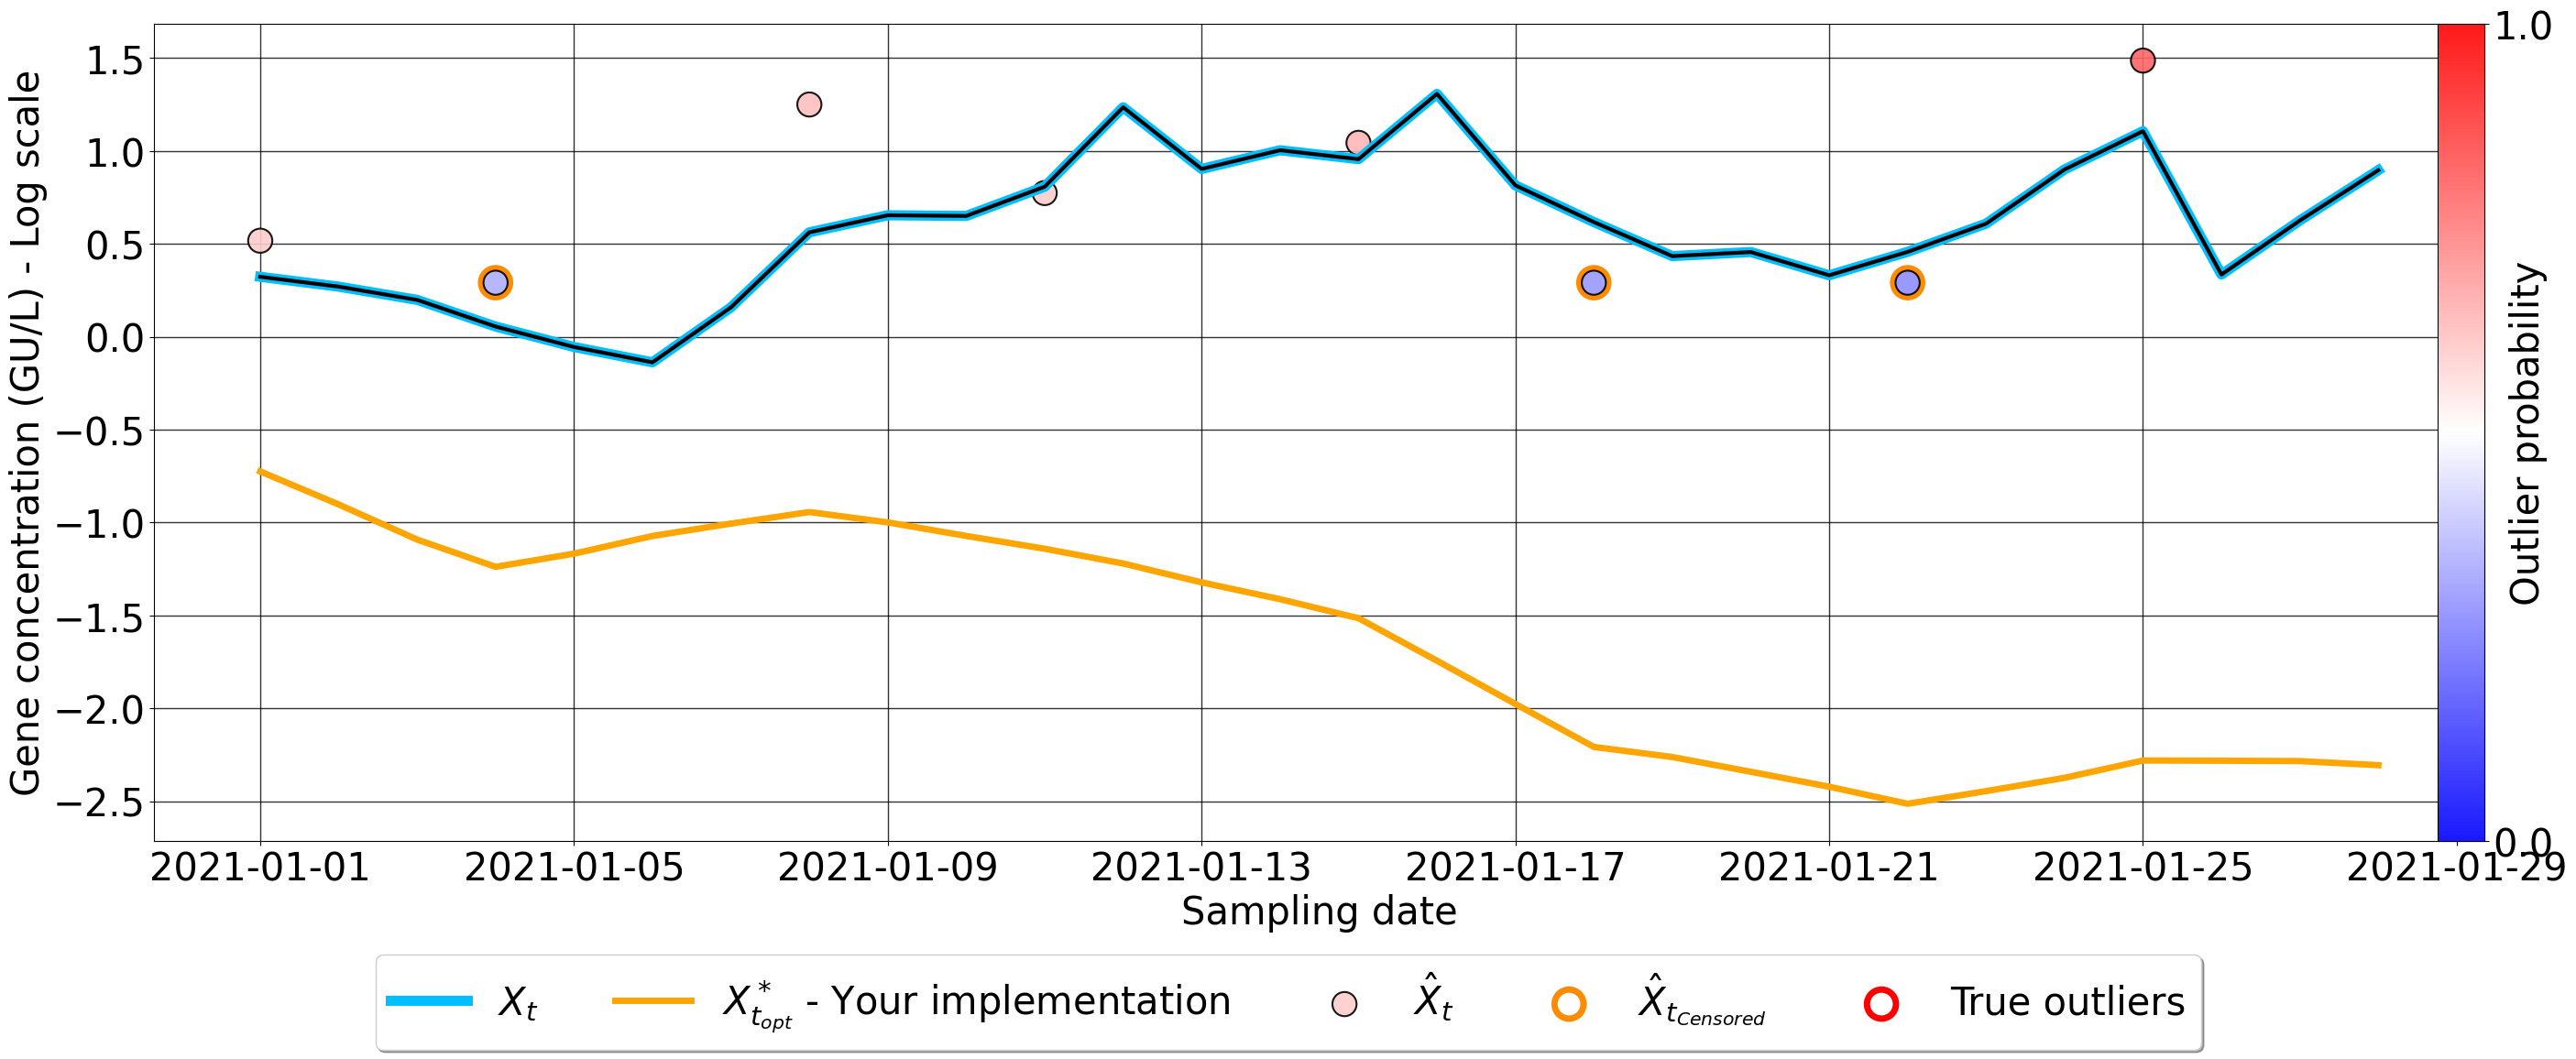

In [34]:
seed = 121
nb_states = 600

nb_chains = 3
tuning_iters = 4000
sampling_iters = 2000

gt_sig = 0.25
gt_eps = 0.4
gt_pout = 0.03

df, outliers_indexes, thresh = generate_data(seed=seed, gt_sig=gt_sig, gt_eps=gt_eps, gt_pOut_g=gt_pout, nsteps=28)

lod_vect = np.ones(df.shape[0]) * thresh
observation_vect = df.Yt.values
 
t0 = time.time()
scou = SCOU(observation_vect, lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()
selected_chains = np.arange(nb_chains)
scou.predict(selected_chains)
scou.compute_pointwise_outlier_probabilities(selected_chains)

estimated_sig = scou.SCOU_traces['posterior']['sig'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_eps = scou.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_p_out = scou.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()

t1 = time.time()

print("Computation took " + str(t1 - t0) + "seconds.")
visualize_smoothed_data(df, outliers_indexes, scou, solution=None, visualize_solution=False)

**Question 5** : Application à deux autre cas très particuliers : grande proportion de valeurs censurées. Commenter.

**Cas 1**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 178 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.232  0.071   0.112    0.371      0.012    0.009      37.0     105.0   
eps    0.469  0.129   0.232    0.716      0.004    0.003     994.0    1393.0   
p_out  0.062  0.033   0.009    0.123      0.000    0.000    4145.0    4093.0   

       r_hat  
sig     1.07  
eps     1.01  
p_out   1.00  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.232  0.071   0.112    0.371      0.012    0.009      37.0     105.0   
eps    0.469  0.129   0.232    0.716      0.004    0.003     994.0    1393.0   
p_out  0.062  0.033   0.009    0.123      0.000    0.000    4145.0    4093.0   

       r_hat  
sig     1.07  
eps     1.01  
p_out   1.00  
Computation took 219.40732097625732seconds.


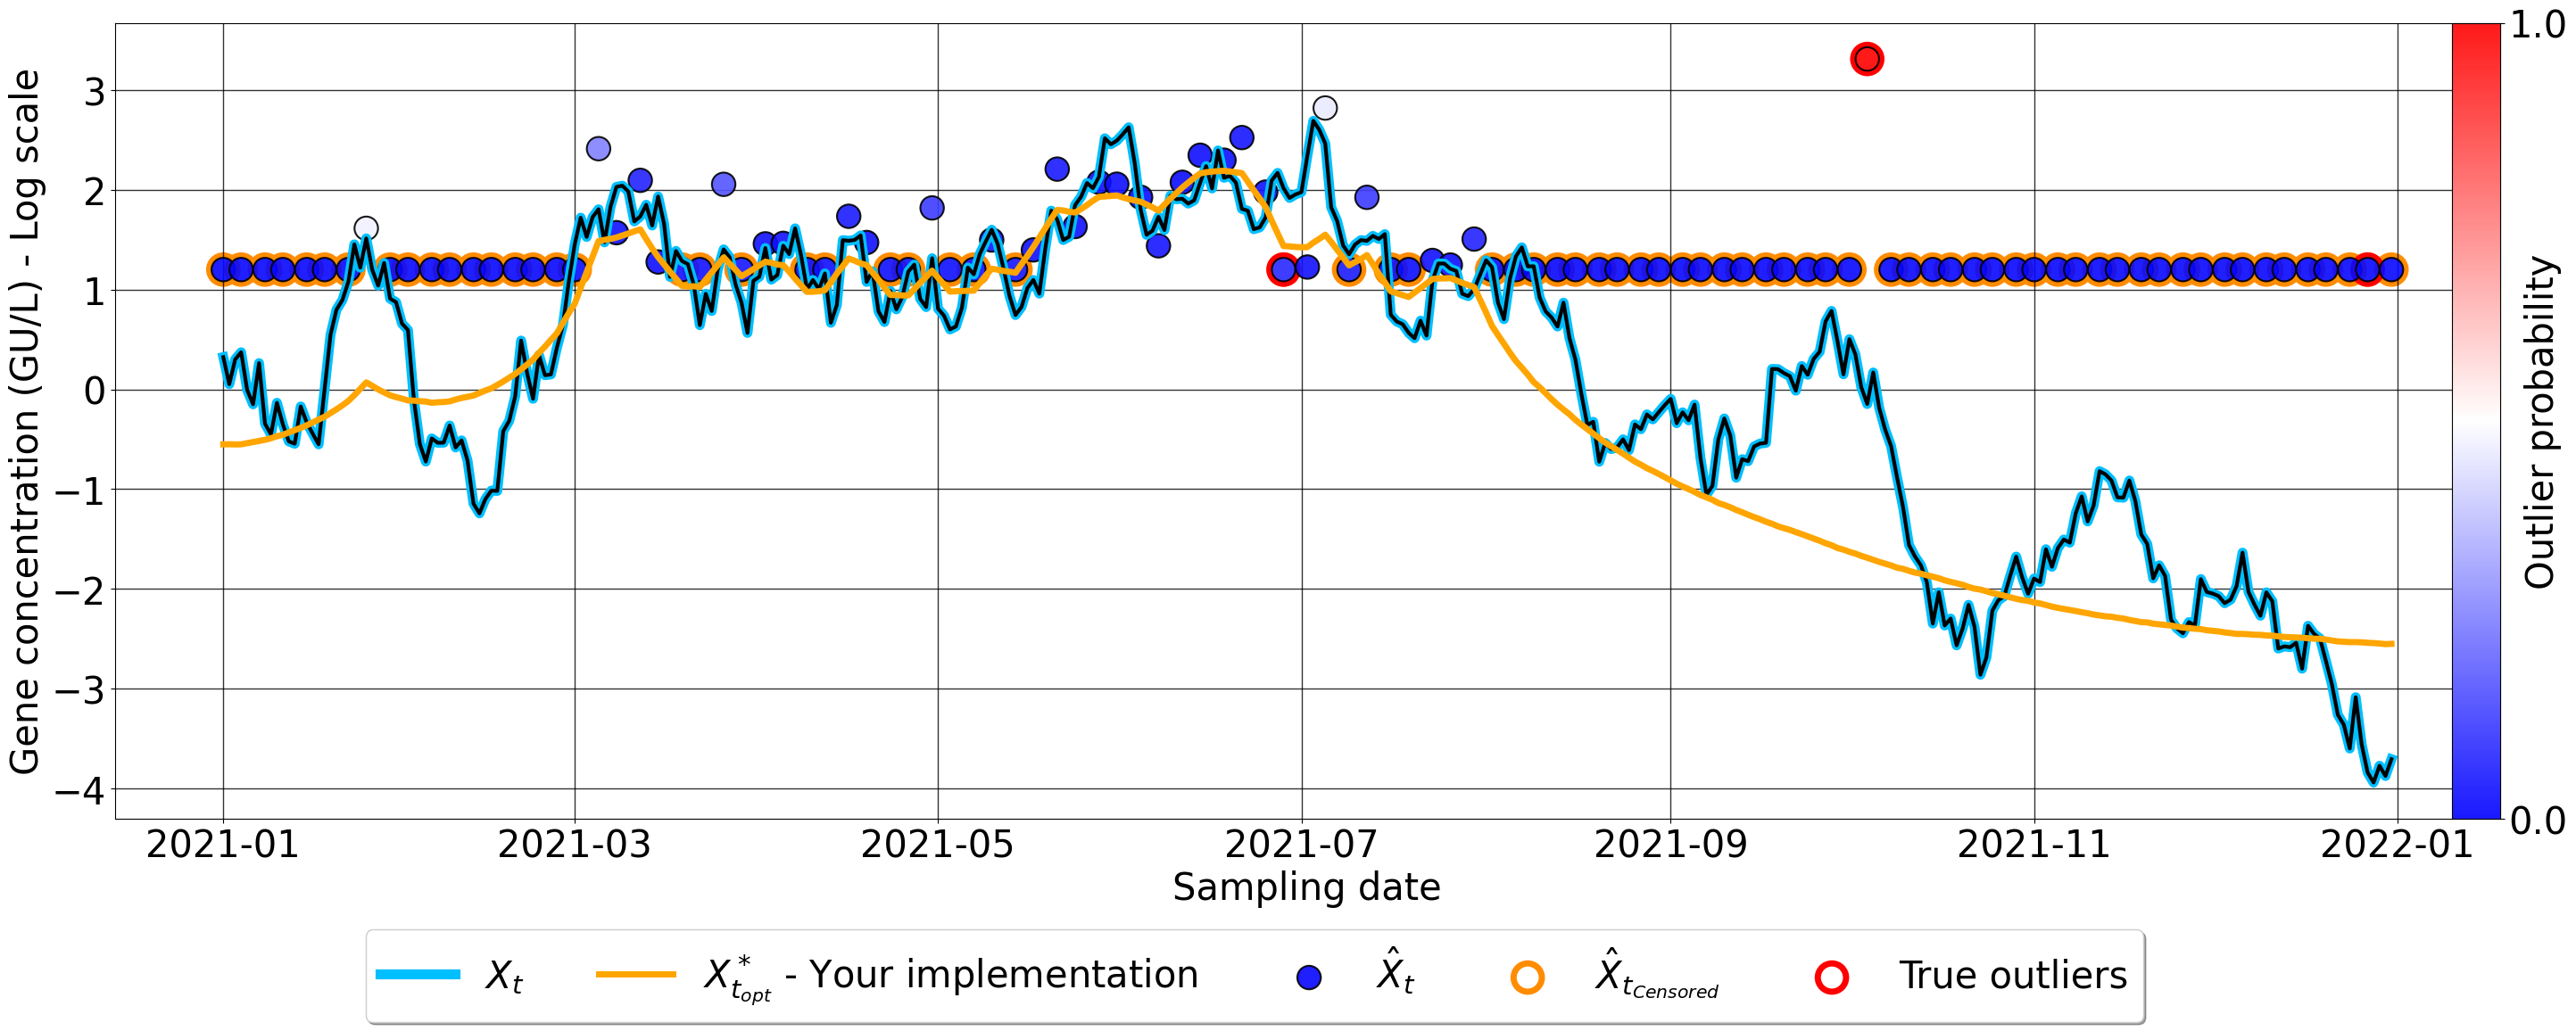

In [36]:
seed = 123
nb_states = 600

nb_chains = 3
tuning_iters = 4000
sampling_iters = 2000

gt_sig = 0.25
gt_eps = 0.4
gt_pout = 0.03

df, outliers_indexes, thresh = generate_data(seed=seed, gt_sig=gt_sig, gt_eps=gt_eps, gt_pOut_g=gt_pout, nsteps=365, censored_proportion=70)

lod_vect = np.ones(df.shape[0]) * thresh
observation_vect = df.Yt.values
 
t0 = time.time()
scou = SCOU(observation_vect, lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()
selected_chains = np.arange(nb_chains)
scou.predict(selected_chains)
scou.compute_pointwise_outlier_probabilities(selected_chains)

estimated_sig = scou.SCOU_traces['posterior']['sig'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_eps = scou.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_p_out = scou.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()

t1 = time.time()

print("Computation took " + str(t1 - t0) + "seconds.")
visualize_smoothed_data(df, outliers_indexes, scou, solution=None, visualize_solution=False)

**Cas 2**

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [sig, eps, p_out, latent]


Sampling 3 chains for 4_000 tune and 2_000 draw iterations (12_000 + 6_000 draws total) took 2743 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Raw summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.257  0.117   0.101    0.446      0.020    0.014      25.0      63.0   
eps    0.377  0.186   0.110    0.709      0.005    0.004    1895.0    2331.0   
p_out  0.053  0.027   0.008    0.102      0.001    0.000    2821.0    3679.0   

       r_hat  
sig     1.11  
eps     1.00  
p_out   1.00  
Best chain combination summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
sig    0.257  0.117   0.101    0.446      0.020    0.014      25.0      63.0   
eps    0.377  0.186   0.110    0.709      0.005    0.004    1895.0    2331.0   
p_out  0.053  0.027   0.008    0.102      0.001    0.000    2821.0    3679.0   

       r_hat  
sig     1.11  
eps     1.00  
p_out   1.00  
Computation took 2784.757176876068seconds.


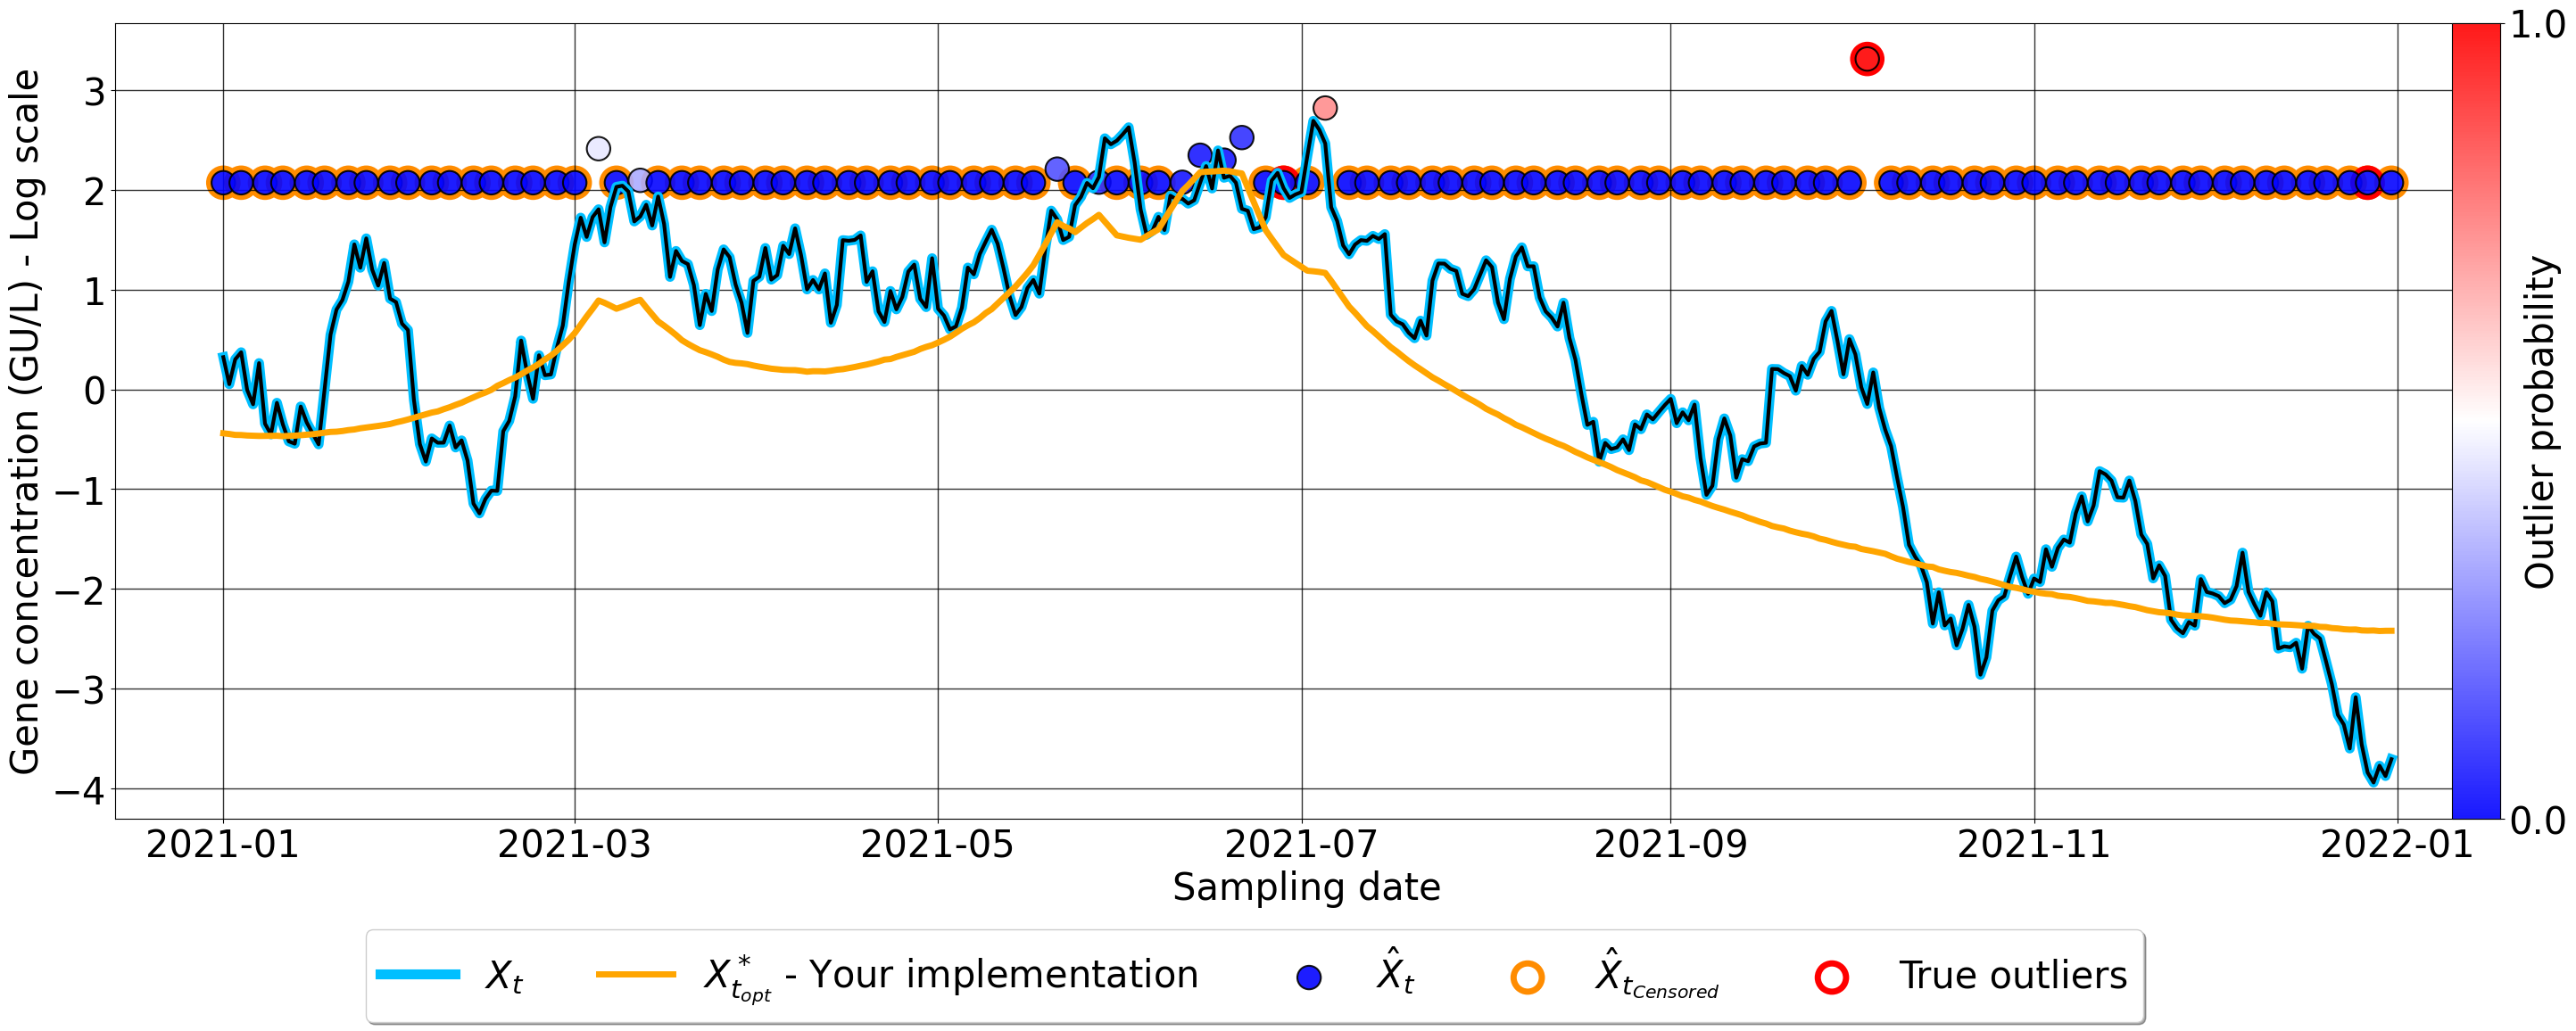

In [37]:
seed = 123
nb_states = 600

nb_chains = 3
tuning_iters = 4000
sampling_iters = 2000

gt_sig = 0.25
gt_eps = 0.4
gt_pout = 0.03

df, outliers_indexes, thresh = generate_data(seed=seed, gt_sig=gt_sig, gt_eps=gt_eps, gt_pOut_g=gt_pout, nsteps=365, censored_proportion=95)

lod_vect = np.ones(df.shape[0]) * thresh
observation_vect = df.Yt.values
 
t0 = time.time()
scou = SCOU(observation_vect, lod_vect, tuning_iters=tuning_iters, sampling_iters=sampling_iters,
                             export_name=None, 
                             p_out_frozen=False, nb_chains=nb_chains, export_chains=False,
                             RW_order=1)
scou.fit()
selected_chains = np.arange(nb_chains)
scou.predict(selected_chains)
scou.compute_pointwise_outlier_probabilities(selected_chains)

estimated_sig = scou.SCOU_traces['posterior']['sig'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_eps = scou.SCOU_traces['posterior']['eps'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()
estimated_p_out = scou.SCOU_traces['posterior']['p_out'].values[selected_chains].reshape(nb_chains * sampling_iters).mean()

t1 = time.time()

print("Computation took " + str(t1 - t0) + "seconds.")
visualize_smoothed_data(df, outliers_indexes, scou, solution=None, visualize_solution=False)